## Imports

In [1]:
import torch
import matplotlib.pyplot as plt
import random
from torchvision import datasets, transforms
from tqdm import tqdm

In [2]:
from lstm import LSTM
from ddpm import UNET, inference
from grayscott import GrayScott, laplacian
from training import train_lstm, train_ddpm
from constants import *

## Device

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## LSTM Dataset

In [4]:
def create_sine_dataset(samples=100, seq_len=50):
    data = []
    for _ in range(samples):
        # Random frequency and phase to make it robust
        freq = np.random.uniform(0.5, 2.0)
        phase = np.random.uniform(0, 2*np.pi)
        t = np.linspace(0, 10, seq_len)
        
        # Signal = Sine + slight noise
        signal = np.sin(freq * t + phase) + 0.05 * np.random.randn(seq_len)
        data.append(signal)
    
    # Shape: [Batch, Seq_Len, Input_Size=1]
    return torch.FloatTensor(np.array(data)).unsqueeze(2)

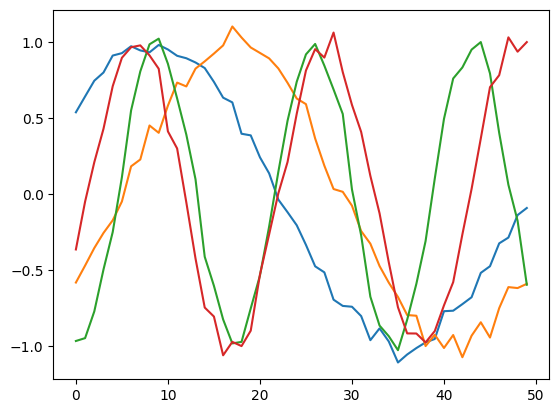

In [5]:
samples = create_sine_dataset(100,50)
samples.size()
for _ in range(4):
    rand_index = random.randint(0, 100)
    plt.plot(samples[rand_index,:,0])

In [6]:
def create_lorenz_dataset(samples=100, seq_len=100, dt=0.01):
    """
    Generates chaotic time series data from the Lorenz Attractor.
    """
    data = []
    # Lorenz Parameters
    sigma, rho, beta = 10.0, 28.0, 8.0/3.0
    
    for _ in range(samples):
        # Random start state
        state = np.random.randn(3)
        sequence = []
        
        for _ in range(seq_len):
            x, y, z = state
            # Euler Integration
            dx = sigma * (y - x)
            dy = x * (rho - z) - y
            dz = x * y - beta * z
            
            state = state + np.array([dx, dy, dz]) * dt
            # We only use the 'x' dimension for the 1D LSTM task
            sequence.append(state[0])
            
        data.append(sequence)
    
    # Normalize to [-1, 1] for LSTM stability
    data = np.array(data)
    data = (data - np.mean(data)) / np.std(data)
    
    return torch.FloatTensor(data).unsqueeze(2) # [Batch, Seq, 1]

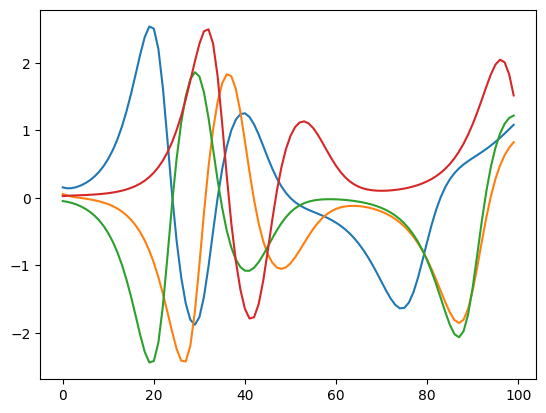

In [7]:
samples_lorenz = create_lorenz_dataset(100, 100, 0.02)
samples_lorenz.size()
for _ in range(4):
    rand_index = random.randint(0, 100)
    plt.plot(samples_lorenz[rand_index,:,0])

In [41]:
def create_vanderpol_dataset(samples=1000, seq_len=50):
    data = []

    dt = 0.05
    mu = 2.0 # High damping = stiffer jumps
    for _ in range(samples):
        x = np.random.uniform(-1, 1)
        y = np.random.uniform(-1, 1) # y is x_dot
        seq = []
        for _ in range(seq_len):
            dx = y
            dy = mu * (1 - x**2) * y - x
            x += dx * dt
            y += dy * dt
            seq.append(x)
        data.append(seq)

    # Convert to Tensor and Normalize to [-1, 1]
    data = np.array(data)
    mean = np.mean(data)
    std = np.std(data)
    data_norm = (data - mean) / (std + 1e-6)
    
    return torch.FloatTensor(data_norm).unsqueeze(2)

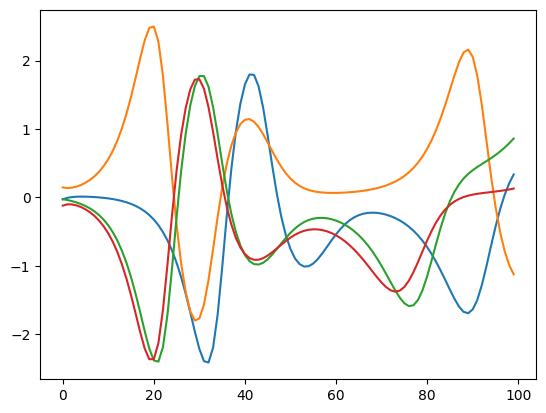

In [46]:
samples_vanderpol = create_vanderpol_dataset(100, 100)
samples_vanderpol.size()
for _ in range(4):
    rand_index = random.randint(0, 100)
    plt.plot(samples_lorenz[rand_index,:,0])

## LSTM Training

In [8]:
n_samples = 10000
seq_len = 100
n_epochs = 200

In [ ]:
lstm_data_sine = create_sine_dataset(samples=n_samples, seq_len=seq_len).to(device)
lstm_data_lorenz = create_lorenz_dataset(samples=n_samples, seq_len=seq_len, dt=0.02).to(device)
lstm_data_vanderpol = create_vanderpol_dataset(samples=n_samples, seq_len=seq_len).to(device)
lstm_model_sine = LSTM(input_size=1, hidden_size=16).to(device)
lstm_model_lorenz = LSTM(input_size=1, hidden_size=16).to(device)
lstm_model_vanderpol = LSTM(input_size=1, hidden_size=16).to(device)

In [47]:
lstm_data_vanderpol = create_vanderpol_dataset(samples=n_samples, seq_len=seq_len).to(device)
lstm_model_vanderpol = LSTM(input_size=1, hidden_size=16).to(device)

--- Training LSTM on cpu ---
Epoch 0: Loss 0.51773
Epoch 10: Loss 0.38609
Epoch 20: Loss 0.24962
Epoch 30: Loss 0.18622
Epoch 40: Loss 0.14756
Epoch 50: Loss 0.12296
Epoch 60: Loss 0.10692
Epoch 70: Loss 0.09709
Epoch 80: Loss 0.09000
Epoch 90: Loss 0.08377
Epoch 100: Loss 0.07882
Epoch 110: Loss 0.07527
Epoch 120: Loss 0.07200
Epoch 130: Loss 0.07011
Epoch 140: Loss 0.06942
Epoch 150: Loss 0.06892
Epoch 160: Loss 0.06818
Epoch 170: Loss 0.07517
Epoch 180: Loss 0.07532
Epoch 190: Loss 0.07413


Text(0.5, 0, 'epoch')

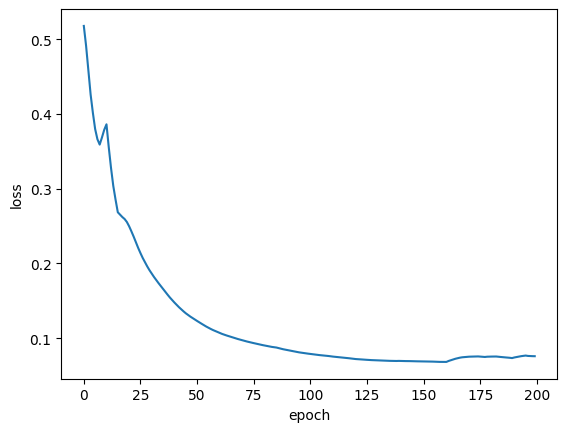

In [10]:
loss_lstm_sine = train_lstm(lstm_model_sine, lstm_data_sine, num_epochs=n_epochs, lr=1e-2, device=device)

plt.plot(loss_lstm_sine)
plt.ylabel("loss")
plt.xlabel("epoch")

Seed shape: torch.Size([100, 1])
Seed values: tensor([[0.6599],
        [0.6812],
        [0.7715],
        [0.7987],
        [0.8500]])
Generated shape: torch.Size([200, 1])
Generated values: tensor([[0.7663],
        [0.9725],
        [0.6485],
        [0.3424],
        [0.4016]])


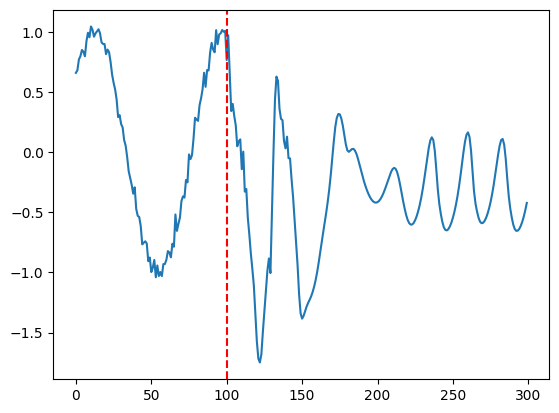

In [11]:
rand_index = random.randint(0, n_samples)
seed_sample = lstm_data_sine[rand_index]

future_steps = 2*seq_len
generated_sine, history_generated_sine = lstm_model_sine.generate_sequence(seed_sample, future_steps=future_steps)

print(f"Seed shape: {seed_sample.shape}")
print(f"Seed values: {seed_sample[:5]}")
print(f"Generated shape: {generated_sine.shape}")
print(f"Generated values: {generated_sine[:5]}")

plt.plot(torch.cat((seed_sample.to("cpu"), generated_sine.to("cpu"))))
plt.axvline(x=seq_len, color='red', linestyle='--')

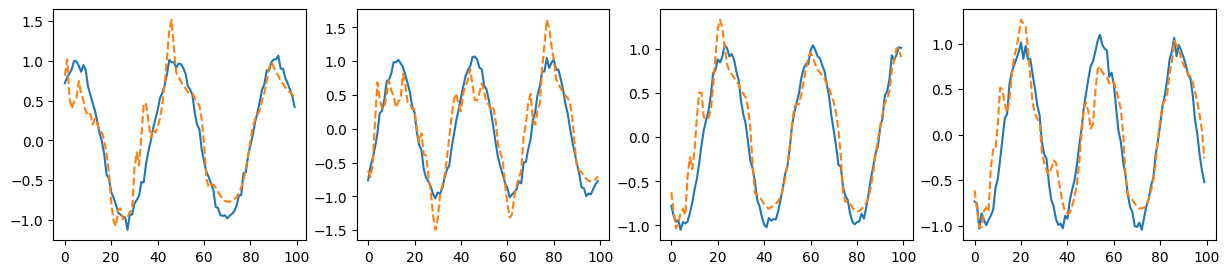

In [12]:
lstm_out_sine, history_lstm_sine = lstm_model_sine(lstm_data_sine)
fig, ax = plt.subplots(1,4, figsize=(15,3))
for i in range(4):
    rand_index = random.randint(0,n_samples)
    ax[i].plot(lstm_data_sine[rand_index,:,0].to("cpu").detach().numpy(), label="true data")
    ax[i].plot(lstm_out_sine[rand_index,:,0].to("cpu").detach().numpy(), linestyle="--", label="lstm output")

plt.show()

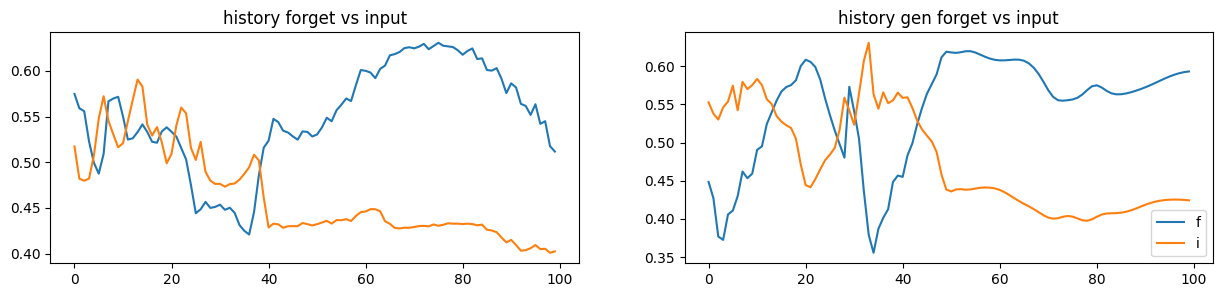

In [13]:
rand_index = random.randint(0,n_samples)
forget_sine = [[t[rand_index, d].item() for t in history_lstm_sine["forget"]] for d in range(16)]
input_sine = [[t[rand_index, d].item() for t in history_lstm_sine["input"]] for d in range(16)]
forget_sine_gen = [[t[0, d].item() for t in history_generated_sine["forget"]] for d in range(16)]
input_sine_gen = [[t[0, d].item() for t in history_generated_sine["input"]] for d in range(16)]

def mean_forget(forget):
    l = []
    s = 0
    for j in range(seq_len):
        for i in range(16):
            s += forget[i][j]
        l.append(s/16)
        s=0
    return l

forget_mean_sine = mean_forget(forget_sine)
input_mean_sine = mean_forget(input_sine)
forget_mean_sine_gen = mean_forget(forget_sine_gen)
input_mean_sine_gen = mean_forget(input_sine_gen)

fix, ax = plt.subplots(1,2, figsize=(15,3))
ax[0].plot(forget_mean_sine, label="f")
ax[0].plot(input_mean_sine, label="i")
ax[0].set_title("history forget vs input")
ax[1].plot(forget_mean_sine_gen, label="f")
ax[1].plot(input_mean_sine_gen, label="i")
ax[1].set_title("history gen forget vs input")
plt.legend()
plt.show()

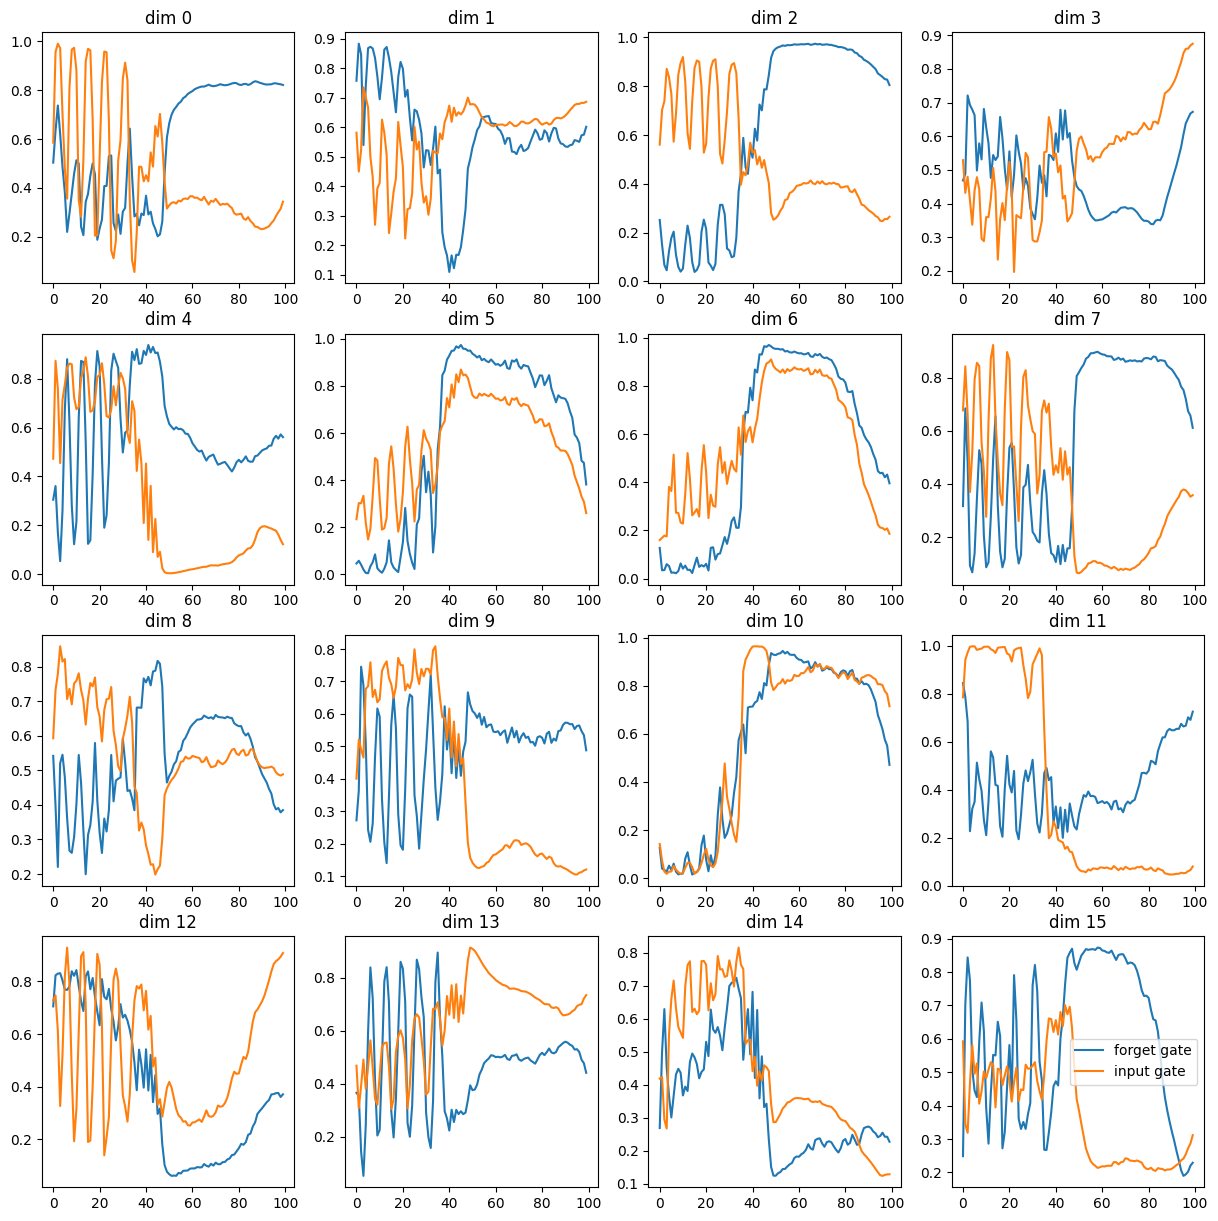

In [14]:
fig, ax = plt.subplots(4,4, figsize=(15,15))

rand_sample = random.randint(0,100)
forget_gate_sine = [[t[rand_sample, d].item() for t in history_lstm_sine["forget"]] for d in range(16)]
input_gate_sine = [[t[rand_sample, d].item() for t in history_lstm_sine["input"]] for d in range(16)]

for i in range(4):
    for j in range(4):
        ax[i,j].plot(forget_gate_sine[4*i+j], label="forget gate")
        ax[i,j].plot(input_gate_sine[4*i+j], label="input gate")
        ax[i,j].set_title(f"dim {4*i+j}")

plt.legend()
plt.show()

--- Training LSTM on cpu ---
Epoch 0: Loss 1.10052
Epoch 10: Loss 0.57026
Epoch 20: Loss 0.32120
Epoch 30: Loss 0.16732
Epoch 40: Loss 0.09848
Epoch 50: Loss 0.05976
Epoch 60: Loss 0.04137
Epoch 70: Loss 0.02855
Epoch 80: Loss 0.02138
Epoch 90: Loss 0.01664
Epoch 100: Loss 0.01323
Epoch 110: Loss 0.01091
Epoch 120: Loss 0.00941
Epoch 130: Loss 0.00834
Epoch 140: Loss 0.00750
Epoch 150: Loss 0.00680
Epoch 160: Loss 0.00622
Epoch 170: Loss 0.00572
Epoch 180: Loss 0.00529
Epoch 190: Loss 0.00492


Text(0.5, 0, 'epoch')

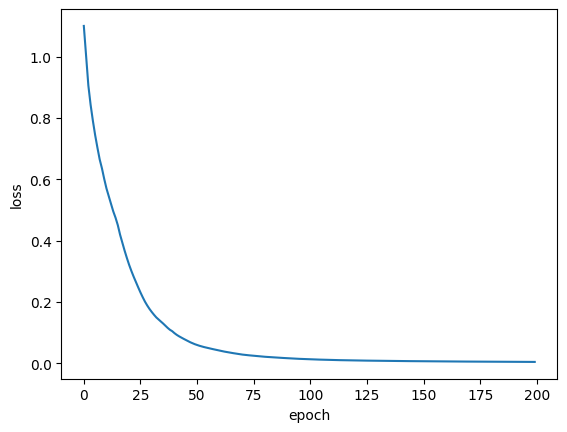

In [15]:
loss_lstm_lorenz = train_lstm(lstm_model_lorenz, lstm_data_lorenz, num_epochs=n_epochs, lr=1e-2, device=device)

plt.plot(loss_lstm_lorenz)
plt.ylabel("loss")
plt.xlabel("epoch")

Seed shape: torch.Size([100, 1])
Seed values: tensor([[0.1688],
        [0.1685],
        [0.1869],
        [0.2197],
        [0.2657]])
Generated shape: torch.Size([200, 1])
Generated values: tensor([[0.1788],
        [0.3534],
        [0.6387],
        [0.9779],
        [1.2181]])


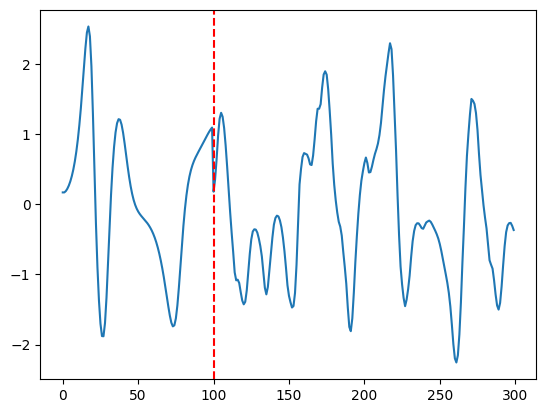

In [16]:
rand_index = random.randint(0, n_samples)
seed_sample = lstm_data_lorenz[rand_index]

future_steps = 2*seq_len
generated_lorenz, history_generated_lorenz = lstm_model_lorenz.generate_sequence(seed_sample, future_steps=future_steps)

print(f"Seed shape: {seed_sample.shape}")
print(f"Seed values: {seed_sample[:5]}")
print(f"Generated shape: {generated_lorenz.shape}")
print(f"Generated values: {generated_lorenz[:5]}")

plt.plot(torch.cat((seed_sample.to("cpu"), generated_lorenz.to("cpu"))))
plt.axvline(x=seq_len, color='red', linestyle='--')

--- Training LSTM on cpu ---
Epoch 0: Loss 1.33168
Epoch 10: Loss 0.42010
Epoch 20: Loss 0.06689
Epoch 30: Loss 0.02195
Epoch 40: Loss 0.01267
Epoch 50: Loss 0.00749
Epoch 60: Loss 0.00436
Epoch 70: Loss 0.00332
Epoch 80: Loss 0.00285
Epoch 90: Loss 0.00252
Epoch 100: Loss 0.00231
Epoch 110: Loss 0.00213
Epoch 120: Loss 0.00198
Epoch 130: Loss 0.00184
Epoch 140: Loss 0.00172
Epoch 150: Loss 0.00161
Epoch 160: Loss 0.00152
Epoch 170: Loss 0.00143
Epoch 180: Loss 0.00135
Epoch 190: Loss 0.00128


Text(0.5, 0, 'epoch')

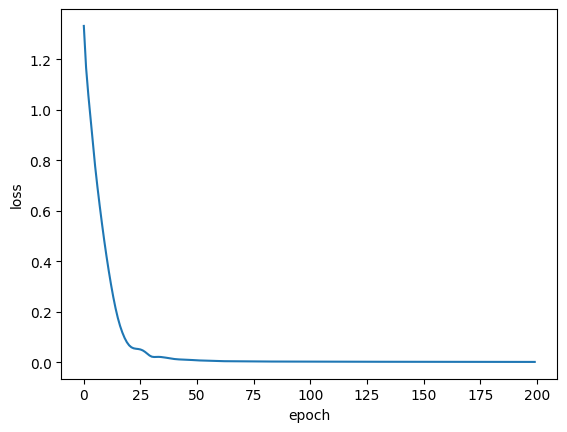

In [48]:
loss_lstm_vanderpol = train_lstm(lstm_model_vanderpol, lstm_data_vanderpol, num_epochs=n_epochs, lr=1e-2, device=device)

plt.plot(loss_lstm_vanderpol)
plt.ylabel("loss")
plt.xlabel("epoch")

Seed shape: torch.Size([100, 1])
Seed values: tensor([[-0.1809],
        [-0.1883],
        [-0.1960],
        [-0.2039],
        [-0.2121]])
Generated shape: torch.Size([200, 1])
Generated values: tensor([[-0.1408],
        [-0.2250],
        [-0.2904],
        [-0.3634],
        [-0.4280]])


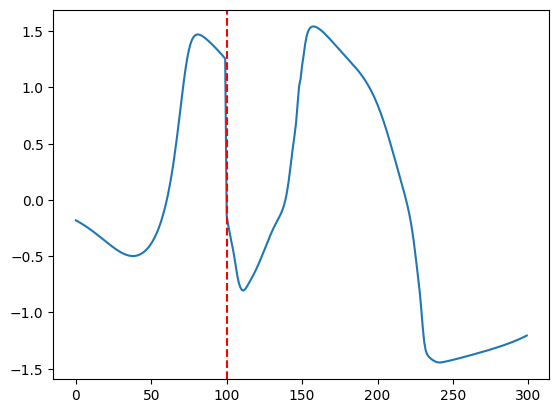

In [53]:
rand_index = random.randint(0, n_samples)
seed_sample = lstm_data_vanderpol[rand_index]

future_steps = 2*seq_len
generated_vanderpol, history_generated_vanderpol = lstm_model_vanderpol.generate_sequence(seed_sample, future_steps=future_steps)

print(f"Seed shape: {seed_sample.shape}")
print(f"Seed values: {seed_sample[:5]}")
print(f"Generated shape: {generated_vanderpol.shape}")
print(f"Generated values: {generated_vanderpol[:5]}")

plt.plot(torch.cat((seed_sample.to("cpu"), generated_vanderpol.to("cpu"))))
plt.axvline(x=seq_len, color='red', linestyle='--')

## DDPM Training

In [17]:
n_epoch = 5
batch_size = 128
n_T = 1000

In [18]:
train_dataset_mnist = datasets.MNIST(root='./data', train=True, download=True,transform=transforms.ToTensor())
train_dataset_fashion = datasets.FashionMNIST(root='./data', train=True, download=True,transform=transforms.ToTensor())
train_dataset_cifar = datasets.CIFAR10(root='./data', train=True, download=True,transform=transforms.ToTensor())

ddpm_model_notrain = UNET(Channels=[32, 64, 128, 256, 256, 192],          # Much smaller
                  Attentions=[False, True, False, False, True, False], # Keep attention sparse
                  Upscales=[False, False, False, True, True, True],
                  num_groups=8  # Reduce groups since channels are smaller
              ).to(device)
ddpm_model_mnist = UNET(Channels=[32, 64, 128, 256, 256, 192],          # Much smaller
                  Attentions=[False, True, False, False, True, False], # Keep attention sparse
                  Upscales=[False, False, False, True, True, True],
                  num_groups=8  # Reduce groups since channels are smaller
              ).to(device)
ddpm_model_fashion = UNET(Channels=[32, 64, 128, 256, 256, 192],          # Much smaller
                  Attentions=[False, True, False, False, True, False], # Keep attention sparse
                  Upscales=[False, False, False, True, True, True],
                  num_groups=8  # Reduce groups since channels are smaller
              ).to(device)
ddpm_model_cifar = UNET(Channels=[32, 64, 128, 256, 256, 192],          # Much smaller
                  Attentions=[False, True, False, False, True, False], # Keep attention sparse
                  Upscales=[False, False, False, True, True, True],
                  num_groups=8,  # Reduce groups since channels are smaller
                  input_channels=3,
                  output_channels=3,
              ).to(device)

Starting inference on cpu with 1000 steps...


999it [00:26, 37.90it/s]


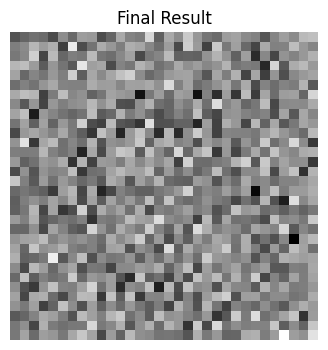

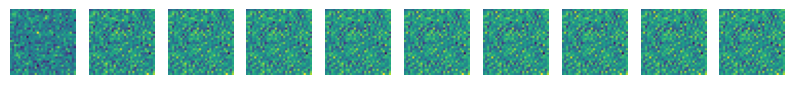

In [19]:
history_ddpm_notrain = inference(ddpm_model=ddpm_model_notrain, num_time_steps=n_T, channels=1, img_size=32)

In [ ]:
losses_ddpm_mnist = train_ddpm(model=ddpm_model_mnist, data=train_dataset_mnist, batch_size=batch_size,num_time_steps=n_T, lr=2e-5, num_epochs=n_epoch, device=device, dataset_size=128)

plt.plot(losses_ddpm_mnist)
plt.ylabel("loss")
plt.xlabel("epoch")

Starting inference on cpu with 1000 steps...


999it [00:48, 20.72it/s]


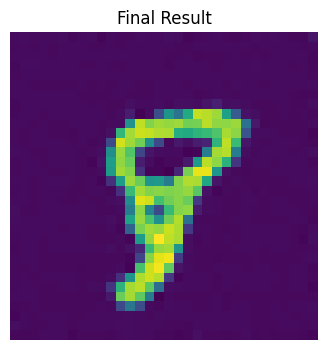

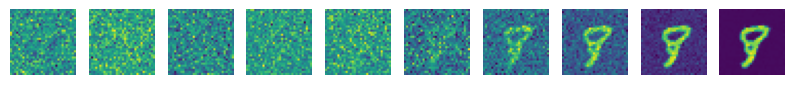

In [ ]:
history_ddpm_mnist = inference(ddpm_model=ddpm_model_mnist, checkpoint_path="checkpoints/ddpm_checkpoint_mnist", num_time_steps=n_T, channels=1, img_size=32)

Starting inference on cpu with 1000 steps...


999it [01:16, 13.09it/s]


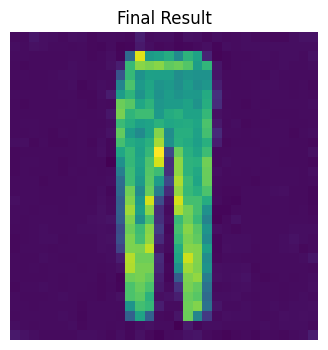

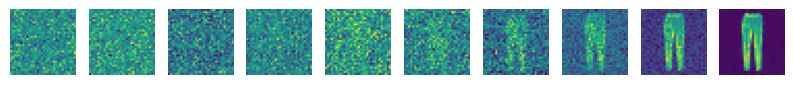

In [ ]:
history_ddpm_fashion = inference(ddpm_model=ddpm_model_fashion, checkpoint_path="checkpoints/ddpm_checkpoint_fashion", num_time_steps=n_T, channels=1, img_size=32)

Starting inference on cpu with 1000 steps...


999it [00:29, 33.80it/s]


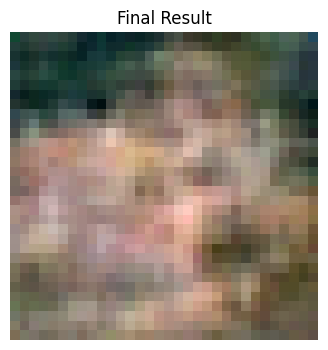

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.462389..4.632906].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.6312566..2.9379265].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.2394712..3.8185291].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.1860385..3.2828465].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.5007246..3.1203246].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7379613..2.6707902].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.85711056

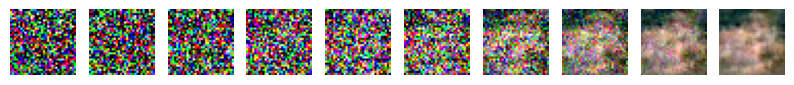

In [20]:
history_ddpm_cifar = inference(ddpm_model=ddpm_model_cifar, checkpoint_path="checkpoints/ddpm_checkpoint_cifar", num_time_steps=n_T, channels=3, img_size=32)

## Comparison

### Helper functions

In [21]:
# import numpy as np
# import matplotlib.pyplot as plt
# from tqdm import tqdm
# import torch
# from grayscott import GrayScott, laplacian

# def run_sweep():
#     # Range of F to sweep (covers extinction, spots, stripes, and chaos)
#     # Pearson classification typically: 
#     # F < 0.01: Extinction
#     # 0.02 < F < 0.04: Spots/Stripes (Stable)
#     # F > 0.06: Chaos/Saturation
#     f_values = np.linspace(0.01, 0.08, 20)
#     k_fixed = 0.062
    
#     ratios = []
#     stability_regimes = []

#     print(f"Starting Parameter Sweep over F (k={k_fixed})...")

#     for f in tqdm(f_values):
#         # Initialize model
#         gs = GrayScott(F=f, k=k_fixed, N=64)
        
#         # Run to equilibrium (or max steps)
#         # We need enough steps for the pattern to emerge
#         for _ in range(15000):
#             gs.step()
        
#         # Measure Forces at steady state
#         U_view = gs.U[1:-1, 1:-1]
#         V_view = gs.V[1:-1, 1:-1]
        
#         # Diffusion Force |D_v * Lap_v|
#         # (Using V usually gives cleaner structure metric for spots)
#         lap_v = laplacian(gs.V, gs.dx)
#         diff_force = np.mean(np.abs(gs.D_v * lap_v))
        
#         # Reaction Force |uv^2 - (F+k)v|
#         uv2 = U_view * V_view**2
#         react_force = np.mean(np.abs(uv2 - (gs.F + gs.k) * V_view))
        
#         # Calculate Ratio
#         if diff_force < 1e-9: # Avoid division by zero in extinction
#             ratio = 0.0
#         else:
#             ratio = react_force / diff_force
            
#         ratios.append(ratio)
        
#         # Simple heuristic for regime classification based on V concentration
#         max_v = np.max(V_view)
#         if max_v < 0.05:
#             stability_regimes.append("Extinction")
#         elif max_v > 0.1:
#             stability_regimes.append("Pattern")
#         else:
#             stability_regimes.append("Unstable")

#     return f_values, ratios, stability_regimes

# def plot_sweep(f_values, ratios, regimes):
#     plt.figure(figsize=(10, 6))
    
#     # Color code the points
#     colors = {'Extinction': 'gray', 'Pattern': 'green', 'Unstable': 'red'}
#     c_map = [colors[r] for r in regimes]
    
#     plt.scatter(f_values, ratios, c=c_map, s=100, zorder=2)
#     plt.plot(f_values, ratios, 'k--', alpha=0.3, zorder=1)
    
#     # Highlight the "Golden Ratio" line
#     plt.axhline(y=1.0, color='blue', linestyle='-', alpha=0.5, label='Perfect Balance (R=1)')
    
#     plt.title("Stability Landscape: Feed Rate vs. Dynamic Balance Ratio")
#     plt.xlabel("Feed Rate (F)")
#     plt.ylabel("Ratio R (Reaction / Diffusion)")
#     plt.grid(True, alpha=0.3)
    
#     # Create custom legend
#     from matplotlib.lines import Line2D
#     legend_elements = [
#         Line2D([0], [0], marker='o', color='w', markerfacecolor='green', label='Stable Pattern'),
#         Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', label='Extinction/Empty'),
#         Line2D([0], [0], marker='o', color='w', markerfacecolor='red', label='Chaos/Saturation'),
#         Line2D([0], [0], color='blue', label='Theory Prediction (R=1)')
#     ]
#     plt.legend(handles=legend_elements)
    
#     plt.savefig("parameter_sweep.png")
#     print("Saved parameter_sweep.png")
#     plt.show()

# f, r, reg = run_sweep()
# plot_sweep(f, r, reg)

In [22]:
def run_rd_exp(history):
    print("=== RD Analysis ===")
    
    diff_forces, react_forces = [], []
    dx = history["dx"]
    F = history["F"]
    k = history["k"]
    D_u = history["D_u"]
    D_v = history["D_v"]

    for t in range(len(history["V"])):
        U_t = history["U"][t]
        V_t = history["V"][t]

        lap_V = torch.tensor(laplacian(V_t, dx))
        f_diff = torch.mean(torch.linalg.norm(D_v * lap_V)).item()

        uv2 = U_t * V_t**2
        reaction_V = torch.tensor(uv2 - (F + k) * V_t)
        f_react = torch.mean(torch.linalg.norm(reaction_V)).item()

        diff_forces.append(f_diff)
        react_forces.append(f_react)

    # Metrics: Mean magnitude per cell
    m_diff = np.mean(diff_forces)
    m_react = np.mean(react_forces)
    
    print(f"RD Diffusion Force: {m_diff}")
    print(f"RD Reaction Force:  {m_react}")
    
    return m_diff, m_react, diff_forces, react_forces


def run_lstm_exp(history):
    print("=== LSTM Analysis ===")

    diff_forces, react_forces = [], []

    for t in range(len(history["input"])):
        i_t = history["input"][t]
        f_t = history["forget"][t]
        C_tilde = history["cell_update"][t]
        C_t = history["cell"][t]
        C_prev = history["cell"][t-1] if t > 0 else torch.zeros_like(C_t)
                
        # Reaction (Restoring Force): 
        # The force pushing the state to the new value (oscillation update)
        # Magnitude of new information injected: |i_t * C_tilde|
        f_react = torch.mean(torch.linalg.norm(i_t * C_tilde)).item()
        
        # Diffusion (Decay/Stabilization):
        # The force eroding the previous state (forgetting)
        # Magnitude of information removed: |(1 - f_t) * C_prev|
        f_diff = torch.mean(torch.linalg.norm((1 - f_t) * C_prev)).item()
        
        diff_forces.append(f_diff)
        react_forces.append(f_react)
            
    m_diff = np.mean(diff_forces)
    m_react = np.mean(react_forces)

    print(f"LSTM Diffusion Force: {m_diff}")
    print(f"LSTM Reaction Force:  {m_react}")
    
    return m_diff, m_react, diff_forces, react_forces

def run_ddpm_exp(history):
    print("=== DDPM Analysis ===")
    drift_forces = []
    noise_forces = []

    for t in range(len(history["time"])):
        drift_vector = torch.tensor(history["drift"][t])
        diffusion_term = torch.tensor(history["diffusion"][t])

        f_react = torch.mean(torch.linalg.norm(drift_vector)).item()
        drift_forces.append(f_react)

        f_diff = torch.mean(torch.linalg.norm(diffusion_term)).item()
        noise_forces.append(f_diff)

    m_diff = np.mean(noise_forces)
    m_react = np.mean(drift_forces)
    
    print(f"DDPM Noise Force (Diff):  {m_diff}")
    print(f"DDPM Drift Force (React): {m_react}")
    
    return m_diff, m_react, noise_forces, drift_forces


### Results

In [ ]:
rd_diff_mean_list, rd_react_mean_list, rd_diff_history_list, rd_react_history_list = [], [], [], []
lstm_diff_mean_list_sine, lstm_react_mean_list_sine, lstm_diff_history_list_sine, lstm_react_history_list_sine = [], [], [], []
lstm_diff_mean_list_lorenz, lstm_react_mean_list_lorenz, lstm_diff_history_list_lorenz, lstm_react_history_list_lorenz = [], [], [], []
lstm_diff_mean_list_vanderpol, lstm_react_mean_list_vanderpol, lstm_diff_history_list_vanderpol, lstm_react_history_list_vanderpol = [], [], [], []
ddpm_diff_mean_list_mnist, ddpm_react_mean_list_mnist, ddpm_diff_history_list_mnist, ddpm_react_history_list_mnist = [], [], [], []
ddpm_diff_mean_list_fashion, ddpm_react_mean_list_fashion, ddpm_diff_history_list_fashion, ddpm_react_history_list_fashion = [], [], [], []
ddpm_diff_mean_list_cifar, ddpm_react_mean_list_cifar, ddpm_diff_history_list_cifar, ddpm_react_history_list_cifar = [], [], [], []

n_simul = 10

In [74]:
F_list = [0.029, 0.0545] # spots to strides
k = 0.062
D_u = 1e-5
D_v = 0.5e-5
T_max = 10000
for f in F_list:
    gs = GrayScott(F=f, k=k,D_u=D_u, D_v=D_v, N=200)
    U, V, V_history, stability_time, diff_history_rd, history_rd = gs.forward(0,T_max, frame=True, data=False)
    rd_diff, rd_react, rd_diff_list, rd_react_list = run_rd_exp(history_rd)
    rd_diff_mean_list.append(rd_diff)
    rd_react_mean_list.append(rd_react)
    rd_diff_history_list.append(rd_diff_list)
    rd_react_history_list.append(rd_react_list)

F=0.029, k=0.062: 100%|████████████████████████████████████████| 5000/5000 [00:20<00:00, 245.90it/s]


=== RD Analysis ===
RD Diffusion Force: 0.355171629534958
RD Reaction Force:  0.3589961417980015


F=0.054, k=0.062: 100%|████████████████████████████████████████| 5000/5000 [00:14<00:00, 351.97it/s]


=== RD Analysis ===
RD Diffusion Force: 0.37078144181606415
RD Reaction Force:  0.37424199156522137


In [25]:
for _ in range(n_simul):
    rand_index = random.randint(0, n_samples)
    seed_sample = lstm_data_sine[rand_index]
    seed_sample_random = torch.randn(seq_len, 1)
    generated_sine, history_lstm_gen_sine = lstm_model_sine.generate_sequence(seed_sample, future_steps=future_steps)
    lstm_diff_sine, lstm_react_sine, lstm_diff_list_sine, lstm_react_list_sine = run_lstm_exp(history_lstm_gen_sine)
    lstm_diff_mean_list_sine.append(lstm_diff_sine)
    lstm_react_mean_list_sine.append(lstm_react_sine)
    lstm_diff_history_list_sine.append(lstm_diff_list_sine)
    lstm_react_history_list_sine.append(lstm_react_list_sine)

=== LSTM Analysis ===
LSTM Diffusion Force: 1.6703761865445717
LSTM Reaction Force:  1.673901546241051
=== LSTM Analysis ===
LSTM Diffusion Force: 1.4903322050918886
LSTM Reaction Force:  1.601980359111
=== LSTM Analysis ===
LSTM Diffusion Force: 1.6623587066204704
LSTM Reaction Force:  1.6794343108507856
=== LSTM Analysis ===
LSTM Diffusion Force: 1.6642710126225073
LSTM Reaction Force:  1.677252880592442
=== LSTM Analysis ===
LSTM Diffusion Force: 1.5833113972266115
LSTM Reaction Force:  1.6380683926481698
=== LSTM Analysis ===
LSTM Diffusion Force: 1.6141227669452303
LSTM Reaction Force:  1.670776812874492
=== LSTM Analysis ===
LSTM Diffusion Force: 1.6564837008265394
LSTM Reaction Force:  1.6765625063498415
=== LSTM Analysis ===
LSTM Diffusion Force: 1.5778617631250889
LSTM Reaction Force:  1.6345577852510327
=== LSTM Analysis ===
LSTM Diffusion Force: 1.595245814203617
LSTM Reaction Force:  1.664989495397213
=== LSTM Analysis ===
LSTM Diffusion Force: 1.6204951899734574
LSTM React

In [35]:
for _ in range(n_simul):
    rand_index = random.randint(0, n_samples)
    seed_sample = lstm_data_lorenz[rand_index]
    seed_sample_random = torch.randn(seq_len, 1)
    generated_lorenz, history_lstm_gen_lorenz = lstm_model_lorenz.generate_sequence(seed_sample, future_steps=future_steps)
    lstm_diff_lorenz, lstm_react_lorenz, lstm_diff_list_lorenz, lstm_react_list_lorenz = run_lstm_exp(history_lstm_gen_lorenz)
    lstm_diff_mean_list_lorenz.append(lstm_diff_lorenz)
    lstm_react_mean_list_lorenz.append(lstm_react_lorenz)
    lstm_diff_history_list_lorenz.append(lstm_diff_list_lorenz)
    lstm_react_history_list_lorenz.append(lstm_react_list_lorenz)

=== LSTM Analysis ===
LSTM Diffusion Force: 1.5141259361451596
LSTM Reaction Force:  1.5978519501698076
=== LSTM Analysis ===
LSTM Diffusion Force: 1.4904222042117286
LSTM Reaction Force:  1.5402627861379978
=== LSTM Analysis ===
LSTM Diffusion Force: 1.5167261576233197
LSTM Reaction Force:  1.5745789663276482
=== LSTM Analysis ===
LSTM Diffusion Force: 1.5535451636542028
LSTM Reaction Force:  1.6210446356229447
=== LSTM Analysis ===
LSTM Diffusion Force: 1.470192206864381
LSTM Reaction Force:  1.5208235857774264
=== LSTM Analysis ===
LSTM Diffusion Force: 1.4765534369490254
LSTM Reaction Force:  1.5455105625205303
=== LSTM Analysis ===
LSTM Diffusion Force: 1.4500097073801799
LSTM Reaction Force:  1.4952696260794922
=== LSTM Analysis ===
LSTM Diffusion Force: 1.558244648291238
LSTM Reaction Force:  1.621754563633521
=== LSTM Analysis ===
LSTM Diffusion Force: 1.557758880769787
LSTM Reaction Force:  1.6226874245471092
=== LSTM Analysis ===
LSTM Diffusion Force: 1.525480379561084
LSTM R

In [56]:
for _ in range(n_simul):
    rand_index = random.randint(0, n_samples)
    seed_sample = lstm_data_vanderpol[rand_index]
    seed_sample_random = torch.randn(seq_len, 1)
    generated_vanderpol, history_lstm_gen_vanderpol = lstm_model_vanderpol.generate_sequence(seed_sample, future_steps=future_steps)
    lstm_diff_vanderpol, lstm_react_vanderpol, lstm_diff_list_vanderpol, lstm_react_list_vanderpol = run_lstm_exp(history_lstm_gen_vanderpol)
    lstm_diff_mean_list_vanderpol.append(lstm_diff_vanderpol)
    lstm_react_mean_list_vanderpol.append(lstm_react_vanderpol)
    lstm_diff_history_list_vanderpol.append(lstm_diff_list_vanderpol)
    lstm_react_history_list_vanderpol.append(lstm_react_list_vanderpol)

=== LSTM Analysis ===
LSTM Diffusion Force: 1.8805646474037938
LSTM Reaction Force:  1.8014554360404087
=== LSTM Analysis ===
LSTM Diffusion Force: 1.9886925227977523
LSTM Reaction Force:  1.9031732708365474
=== LSTM Analysis ===
LSTM Diffusion Force: 1.8587867623597534
LSTM Reaction Force:  1.7815742834129524
=== LSTM Analysis ===
LSTM Diffusion Force: 1.6853481504186314
LSTM Reaction Force:  1.7741421080713895
=== LSTM Analysis ===
LSTM Diffusion Force: 1.8645333632751926
LSTM Reaction Force:  1.7866398599279585
=== LSTM Analysis ===
LSTM Diffusion Force: 1.905458704011524
LSTM Reaction Force:  1.8240022430168323
=== LSTM Analysis ===
LSTM Diffusion Force: 1.6857345218035444
LSTM Reaction Force:  1.7731324206644565
=== LSTM Analysis ===
LSTM Diffusion Force: 1.6838827029844026
LSTM Reaction Force:  1.766595270166445
=== LSTM Analysis ===
LSTM Diffusion Force: 1.685920971422339
LSTM Reaction Force:  1.7724579557701572
=== LSTM Analysis ===
LSTM Diffusion Force: 1.9791633640252166
LSTM

Starting inference on cpu with 1000 steps...


999it [00:26, 37.67it/s]


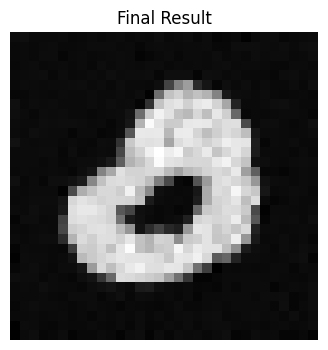

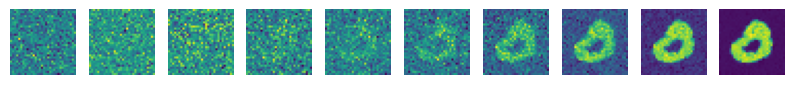

=== DDPM Analysis ===
DDPM Noise Force (Diff):  3.0320103572010995
DDPM Drift Force (React): 0.2124827966094017
Starting inference on cpu with 1000 steps...


999it [00:31, 31.33it/s]


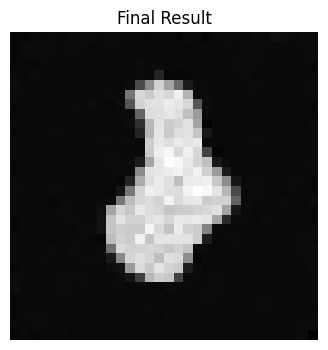

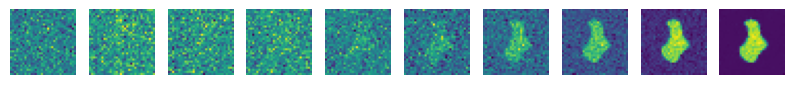

=== DDPM Analysis ===
DDPM Noise Force (Diff):  3.0289770342111586
DDPM Drift Force (React): 0.21309043750166892
Starting inference on cpu with 1000 steps...


999it [00:26, 37.26it/s]


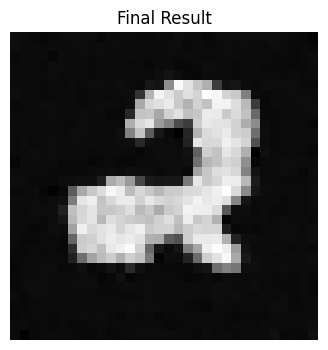

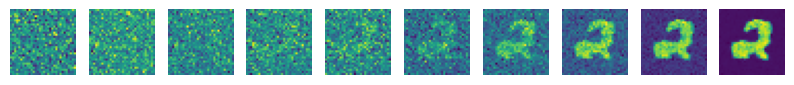

=== DDPM Analysis ===
DDPM Noise Force (Diff):  3.029481096923351
DDPM Drift Force (React): 0.21019102795422076
Starting inference on cpu with 1000 steps...


999it [00:32, 30.87it/s]


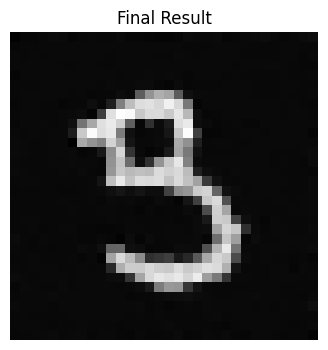

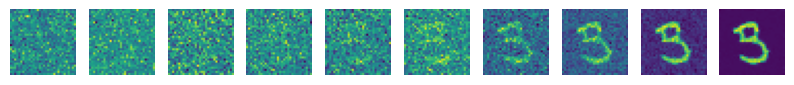

=== DDPM Analysis ===
DDPM Noise Force (Diff):  3.034957684934139
DDPM Drift Force (React): 0.21474974252283574
Starting inference on cpu with 1000 steps...


999it [00:36, 27.72it/s]


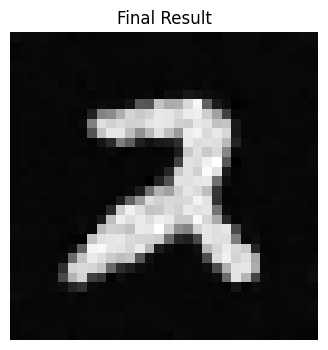

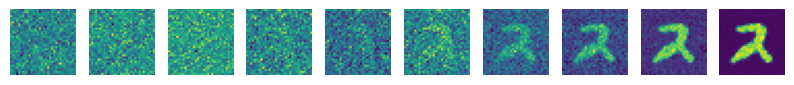

=== DDPM Analysis ===
DDPM Noise Force (Diff):  3.0300706967413427
DDPM Drift Force (React): 0.21285926754772663
Starting inference on cpu with 1000 steps...


999it [00:24, 41.09it/s]


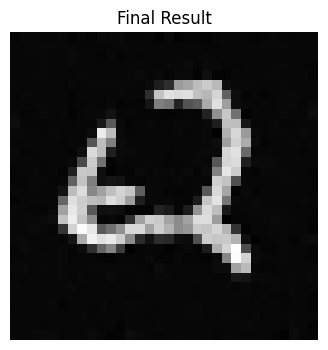

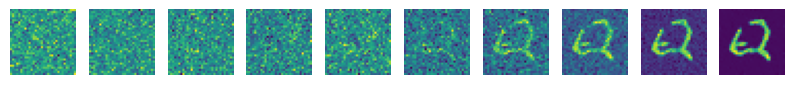

=== DDPM Analysis ===
DDPM Noise Force (Diff):  3.0326580745577814
DDPM Drift Force (React): 0.2130033033490181
Starting inference on cpu with 1000 steps...


999it [00:32, 30.32it/s]


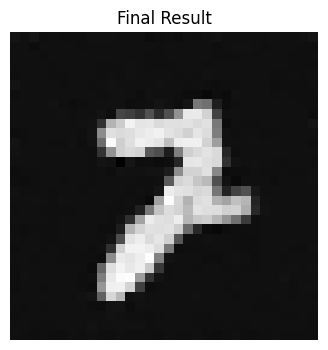

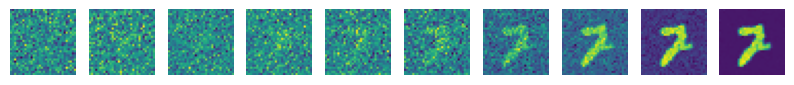

=== DDPM Analysis ===
DDPM Noise Force (Diff):  3.031887631058693
DDPM Drift Force (React): 0.21447822839021682
Starting inference on cpu with 1000 steps...


999it [00:35, 28.46it/s]


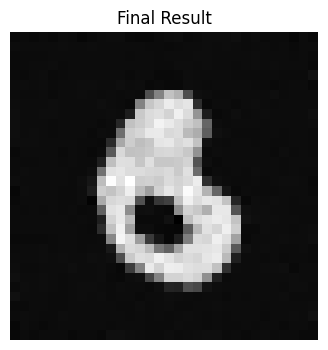

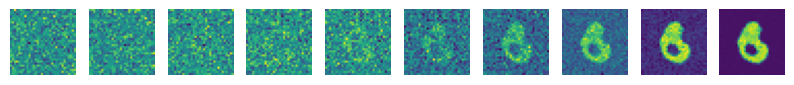

=== DDPM Analysis ===
DDPM Noise Force (Diff):  3.0282235976457597
DDPM Drift Force (React): 0.2154372611939907
Starting inference on cpu with 1000 steps...


999it [00:37, 26.68it/s]


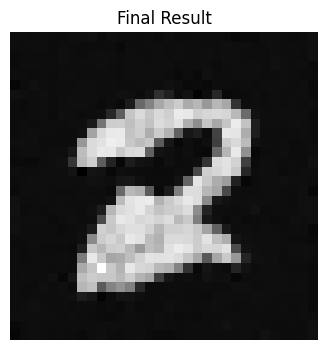

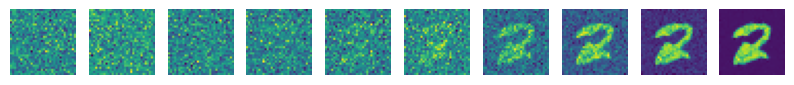

=== DDPM Analysis ===
DDPM Noise Force (Diff):  3.027796835541725
DDPM Drift Force (React): 0.2158478416353464
Starting inference on cpu with 1000 steps...


999it [00:36, 27.33it/s]


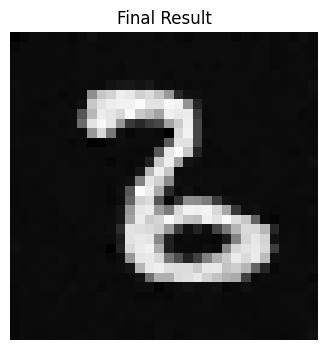

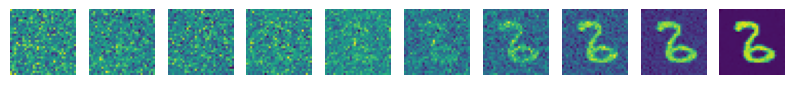

=== DDPM Analysis ===
DDPM Noise Force (Diff):  3.027401505053043
DDPM Drift Force (React): 0.21434120686352254


In [34]:
for _ in range(n_simul):
    history_ddpm_mnist = inference(ddpm_model=ddpm_model_mnist, checkpoint_path="checkpoints/ddpm_checkpoint_mnist", num_time_steps=n_T, channels=1, img_size=32)
    ddpm_diff_mnist, ddpm_react_mnist, ddpm_diff_list_mnist, ddpm_react_list_mnist = run_ddpm_exp(history_ddpm_mnist)
    ddpm_diff_mean_list_mnist.append(ddpm_diff_mnist)
    ddpm_react_mean_list_mnist.append(ddpm_react_mnist)
    ddpm_diff_history_list_mnist.append(ddpm_diff_list_mnist)
    ddpm_react_history_list_mnist.append(ddpm_react_list_mnist)

Starting inference on cpu with 1000 steps...


999it [00:29, 34.39it/s]


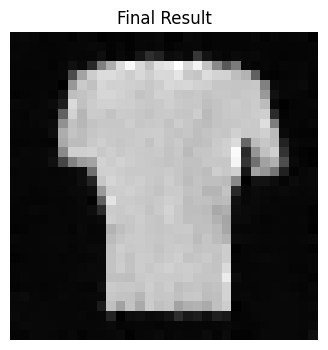

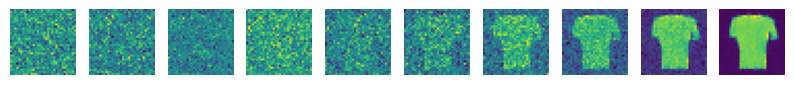

=== DDPM Analysis ===
DDPM Noise Force (Diff):  3.024923998087645
DDPM Drift Force (React): 0.2136717377603054
Starting inference on cpu with 1000 steps...


999it [00:29, 33.97it/s]


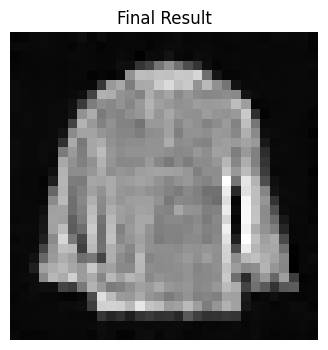

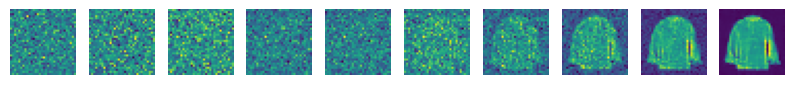

=== DDPM Analysis ===
DDPM Noise Force (Diff):  3.028634067952633
DDPM Drift Force (React): 0.21266179078817368
Starting inference on cpu with 1000 steps...


999it [00:46, 21.44it/s]


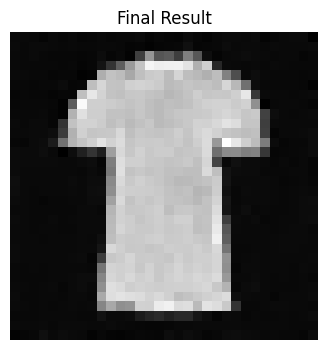

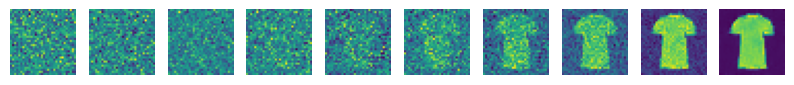

=== DDPM Analysis ===
DDPM Noise Force (Diff):  3.029519683510065
DDPM Drift Force (React): 0.21533209389448166
Starting inference on cpu with 1000 steps...


999it [00:32, 30.85it/s]


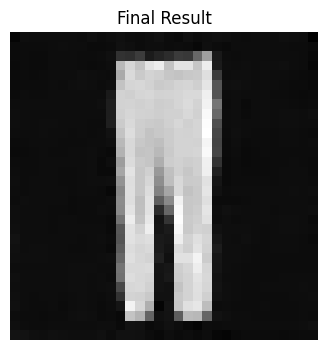

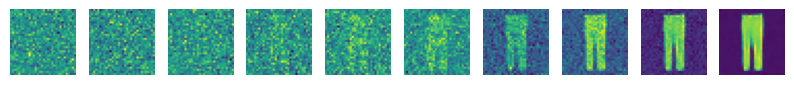

=== DDPM Analysis ===
DDPM Noise Force (Diff):  3.0304384242594242
DDPM Drift Force (React): 0.21648311588168145
Starting inference on cpu with 1000 steps...


999it [00:34, 28.82it/s]


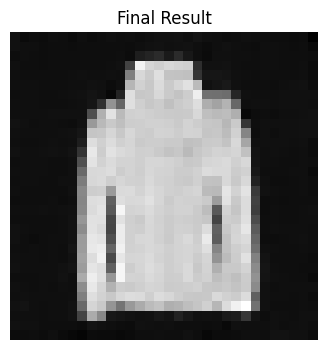

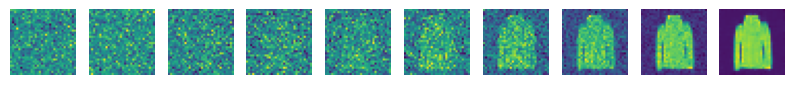

=== DDPM Analysis ===
DDPM Noise Force (Diff):  3.0308340635299684
DDPM Drift Force (React): 0.2151638784557581
Starting inference on cpu with 1000 steps...


999it [00:48, 20.75it/s]


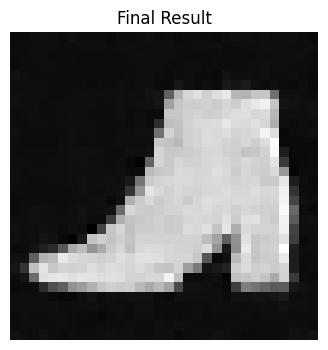

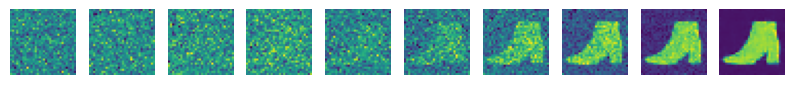

=== DDPM Analysis ===
DDPM Noise Force (Diff):  3.034801290720701
DDPM Drift Force (React): 0.21272367724776267
Starting inference on cpu with 1000 steps...


999it [00:35, 28.02it/s]


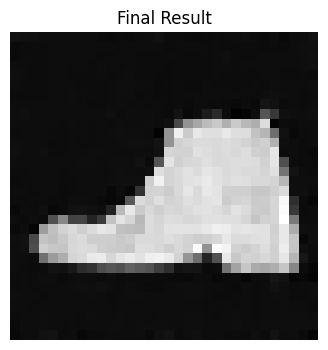

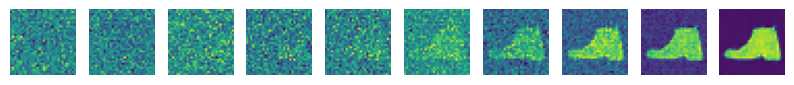

=== DDPM Analysis ===
DDPM Noise Force (Diff):  3.0306254481077195
DDPM Drift Force (React): 0.21369743664562701
Starting inference on cpu with 1000 steps...


999it [00:40, 24.75it/s]


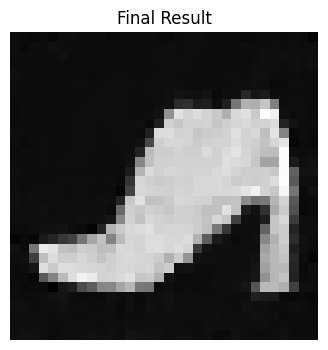

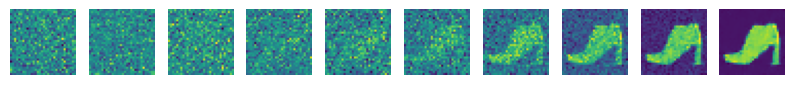

=== DDPM Analysis ===
DDPM Noise Force (Diff):  3.029689144939184
DDPM Drift Force (React): 0.21196925409138204
Starting inference on cpu with 1000 steps...


999it [00:34, 29.33it/s]


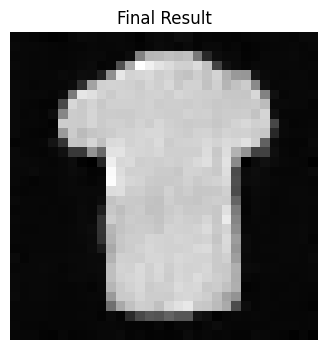

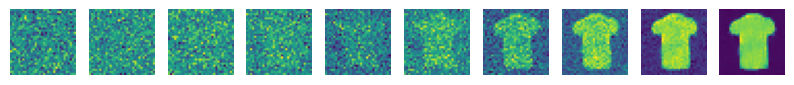

=== DDPM Analysis ===
DDPM Noise Force (Diff):  3.031243852138519
DDPM Drift Force (React): 0.21312476663291455
Starting inference on cpu with 1000 steps...


999it [00:38, 25.87it/s]


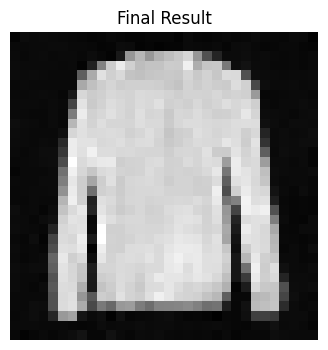

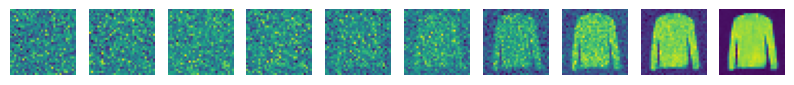

=== DDPM Analysis ===
DDPM Noise Force (Diff):  3.0277720355391504
DDPM Drift Force (React): 0.21525899405777454


In [36]:
for _ in range(n_simul):
    history_ddpm_fashion = inference(ddpm_model=ddpm_model_fashion, checkpoint_path="checkpoints/ddpm_checkpoint_fashion", num_time_steps=n_T, channels=1, img_size=32)
    ddpm_diff_fashion, ddpm_react_fashion, ddpm_diff_list_fashion, ddpm_react_list_fashion = run_ddpm_exp(history_ddpm_fashion)
    ddpm_diff_mean_list_fashion.append(ddpm_diff_fashion)
    ddpm_react_mean_list_fashion.append(ddpm_react_fashion)
    ddpm_diff_history_list_fashion.append(ddpm_diff_list_fashion)
    ddpm_react_history_list_fashion.append(ddpm_react_list_fashion)

Starting inference on cpu with 1000 steps...


999it [00:47, 21.24it/s]


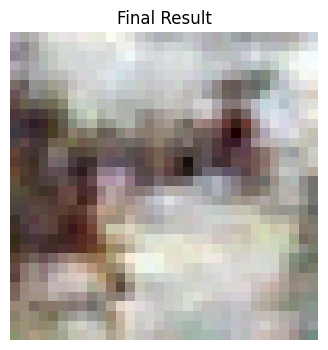

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.8094962..3.6105158].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.9567442..3.7289245].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.2367165..3.8265772].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.6352558..3.4397779].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.2386594..2.8022318].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.3670046..2.6021264].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.700063

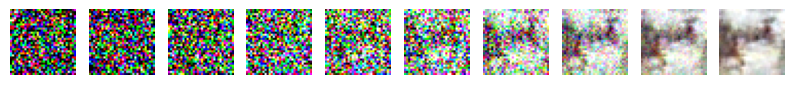

=== DDPM Analysis ===
DDPM Noise Force (Diff):  5.248293078184128
DDPM Drift Force (React): 0.3691214412748814
Starting inference on cpu with 1000 steps...


999it [00:36, 27.27it/s]


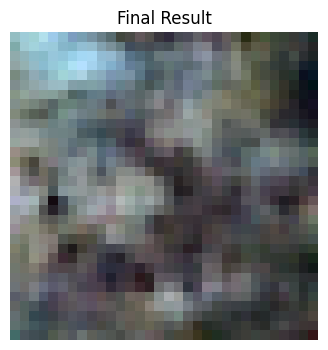

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.902456..4.0859776].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.2079542..3.4890647].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.8983982..3.3552754].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.5456254..3.5781753].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.6726036..3.2539113].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0429149..2.8303785].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9379061

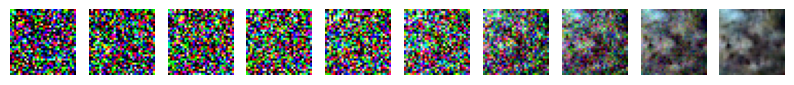

=== DDPM Analysis ===
DDPM Noise Force (Diff):  5.252811797320843
DDPM Drift Force (React): 0.3714737498164177
Starting inference on cpu with 1000 steps...


999it [00:29, 34.16it/s]


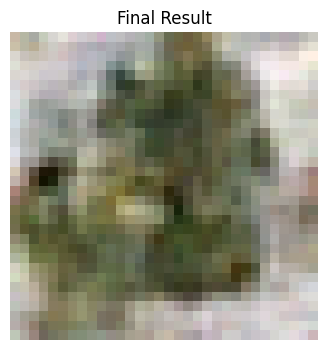

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.2631629..3.7004685].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.7789469..4.102536].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.6213777..3.7150035].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.8169394..3.2578123].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.3284607..3.0359237].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7083728..2.9367454].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7207925

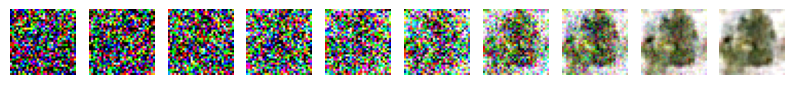

=== DDPM Analysis ===
DDPM Noise Force (Diff):  5.245006521522999
DDPM Drift Force (React): 0.36841143348813055
Starting inference on cpu with 1000 steps...


999it [00:29, 34.20it/s]


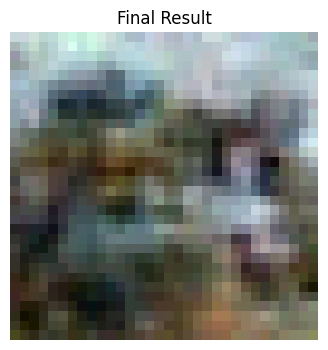

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.5243576..3.3739438].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.7111144..3.9718208].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.3678267..3.3033].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.9828327..4.1388593].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.7663565..3.3072448].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.2037098..2.9938984].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.78236073.

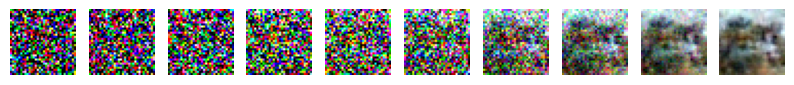

=== DDPM Analysis ===
DDPM Noise Force (Diff):  5.245105799794197
DDPM Drift Force (React): 0.368475861787796
Starting inference on cpu with 1000 steps...


999it [00:28, 35.67it/s]


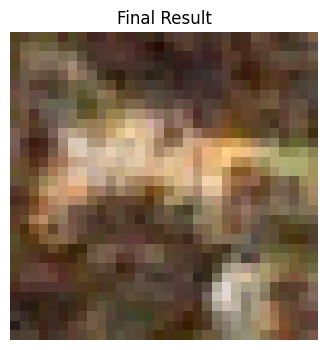

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.3641877..3.1228013].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.185207..3.7062967].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.8187602..3.6917267].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.0191426..3.5473342].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.355777..3.1759882].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0886133..3.0352485].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.86970764

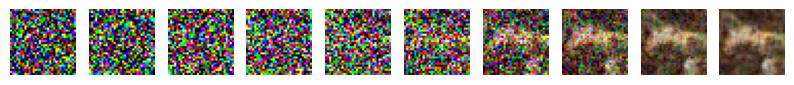

=== DDPM Analysis ===
DDPM Noise Force (Diff):  5.248928349196911
DDPM Drift Force (React): 0.3704184142649174
Starting inference on cpu with 1000 steps...


999it [00:27, 35.87it/s]


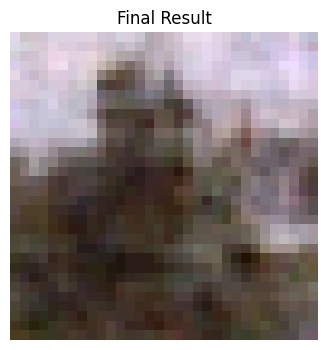

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.2098892..3.4226658].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.3441548..3.4091263].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.3692665..3.4375386].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.6833465..3.945824].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.4443345..2.9687164].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6433562..2.6518595].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0190189

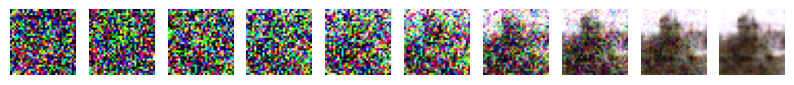

=== DDPM Analysis ===
DDPM Noise Force (Diff):  5.2460611398220065
DDPM Drift Force (React): 0.374724265396595
Starting inference on cpu with 1000 steps...


999it [00:26, 38.10it/s]


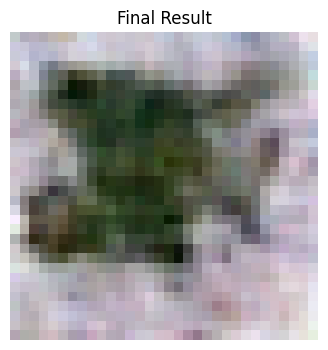

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.1322098..3.347576].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.1187904..3.5574036].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.0467958..3.9132073].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.8075902..3.6386874].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.575862..3.089139].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.5522894..2.6491337].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0698714..

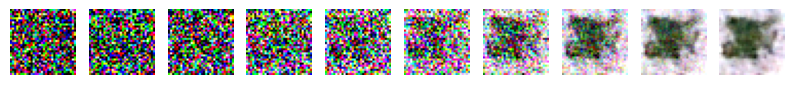

=== DDPM Analysis ===
DDPM Noise Force (Diff):  5.247136095762253
DDPM Drift Force (React): 0.37159263429045675
Starting inference on cpu with 1000 steps...


999it [00:25, 39.63it/s]


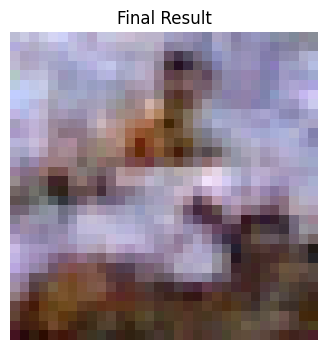

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.021559..3.066781].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.0013306..3.5289805].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.3409336..3.8382728].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.555342..3.4609485].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.1247494..3.241443].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.5669583..2.450374].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6179658..1.

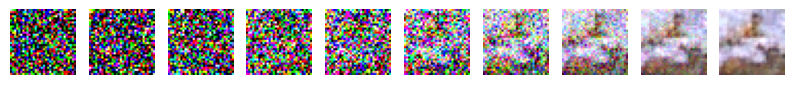

=== DDPM Analysis ===
DDPM Noise Force (Diff):  5.249877349019051
DDPM Drift Force (React): 0.37225328558683396
Starting inference on cpu with 1000 steps...


999it [00:24, 41.28it/s]


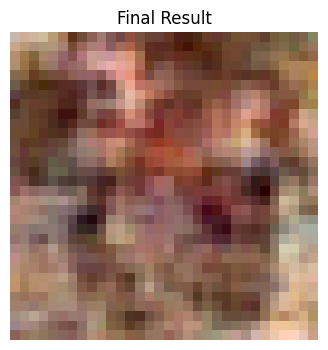

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.4003346..3.4098623].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.6033933..3.443523].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.6983585..3.3454428].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.7554088..3.3168354].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.4752047..2.9078376].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6682119..2.2903974].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8307956

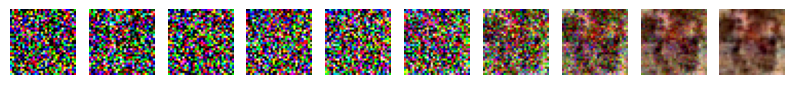

=== DDPM Analysis ===
DDPM Noise Force (Diff):  5.248403297305107
DDPM Drift Force (React): 0.37032043194770814
Starting inference on cpu with 1000 steps...


999it [00:28, 35.24it/s]


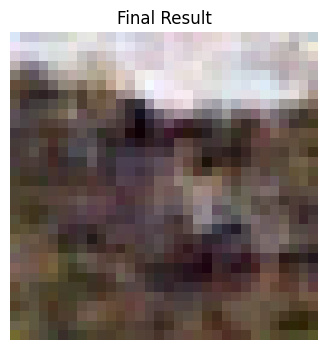

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.64181..3.367395].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.2615297..3.7631805].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.759828..3.1280785].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.9537344..3.282724].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1287076..2.8146017].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.5747396..2.6523366].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7477251..2.

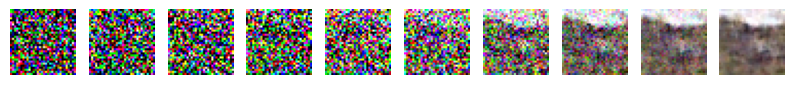

=== DDPM Analysis ===
DDPM Noise Force (Diff):  5.250855338573456
DDPM Drift Force (React): 0.3688607305288315


In [37]:
for _ in range(n_simul):
    history_ddpm_cifar = inference(ddpm_model=ddpm_model_cifar, checkpoint_path="checkpoints/ddpm_checkpoint_cifar", num_time_steps=n_T, channels=3, img_size=32)
    ddpm_diff_cifar, ddpm_react_cifar, ddpm_diff_list_cifar, ddpm_react_list_cifar = run_ddpm_exp(history_ddpm_cifar)
    ddpm_diff_mean_list_cifar.append(ddpm_diff_cifar)
    ddpm_react_mean_list_cifar.append(ddpm_react_cifar)
    ddpm_diff_history_list_cifar.append(ddpm_diff_list_cifar)
    ddpm_react_history_list_cifar.append(ddpm_react_list_cifar)

In [78]:
# Calculate Ratios
rd_ratio_spot = rd_react_mean_list[0] / (rd_diff_mean_list[0] if rd_diff_mean_list[0] != 0 else rd_diff_mean_list[0] + 1e-10)
rd_ratio_stripe = rd_react_mean_list[1] / (rd_diff_mean_list[1] if rd_diff_mean_list[1] != 0 else rd_diff_mean_list[1] + 1e-10)

lstm_ratio_sine = np.mean(lstm_react_list_sine) / np.mean(lstm_diff_list_sine)
lstm_ratio_lorenz = np.mean(lstm_react_list_lorenz) / np.mean(lstm_diff_list_lorenz)
lstm_ratio_vanderpol= np.mean(lstm_react_list_vanderpol) / np.mean(lstm_diff_list_vanderpol)
ddpm_ratio_mnist = np.mean(ddpm_react_list_mnist) / np.mean(ddpm_diff_list_mnist)
ddpm_ratio_fashion = np.mean(ddpm_react_list_fashion) / np.mean(ddpm_diff_list_fashion)
ddpm_ratio_cifar = np.mean(ddpm_react_list_cifar) / np.mean(ddpm_diff_list_cifar)

print(f"{'Model':<20} | {'M_diff (Decay)':<18} | {'M_react (Growth)':<18} | {'Ratio (react/diff)':<15}")
print("-" * 80)
print(f"{'Gray-Scott (spot)':<20} | {rd_diff_mean_list[0]:<18.8f} | {rd_react_mean_list[0]:<18.8f} | {rd_ratio_spot:<15.8f}")
print(f"{'Gray-Scott (stripe)':<20} | {rd_diff_mean_list[1]:<18.8f} | {rd_react_mean_list[1]:<18.8f} | {rd_ratio_stripe:<15.8f}")
print(f"{'LSTM (sine)':<20} | {lstm_diff_sine:<18.8f} | {lstm_react_sine:<18.8f} | {lstm_ratio_sine:<15.8f}")
print(f"{'LSTM (lorenz)':<20} | {lstm_diff_lorenz:<18.8f} | {lstm_react_lorenz:<18.8f} | {lstm_ratio_lorenz:<15.8f}")
print(f"{'LSTM (vanderpol)':<20} | {lstm_diff_vanderpol:<18.8f} | {lstm_react_vanderpol:<18.8f} | {lstm_ratio_vanderpol:<15.8f}")
print(f"{'DDPM (mnist)':<20} | {ddpm_diff_mnist:<18.8f} | {ddpm_react_mnist:<18.8f} | {ddpm_ratio_mnist:<15.8f}")
print(f"{'DDPM (fashion)':<20} | {ddpm_diff_fashion:<18.8f} | {ddpm_react_fashion:<18.8f} | {ddpm_ratio_fashion:<15.8f}")
print(f"{'DDPM (cifar)':<20} | {ddpm_diff_cifar:<18.8f} | {ddpm_react_cifar:<18.8f} | {ddpm_ratio_cifar:<15.8f}")

Model                | M_diff (Decay)     | M_react (Growth)   | Ratio (react/diff)
--------------------------------------------------------------------------------
Gray-Scott (spot)    | 0.35517163         | 0.35899614         | 1.01076807     
Gray-Scott (stripe)  | 0.37078144         | 0.37424199         | 1.00933313     
LSTM (sine)          | 1.62049519         | 1.67321852         | 1.03253532     
LSTM (lorenz)        | 1.52548038         | 1.58362915         | 1.03811833     
LSTM (vanderpol)     | 1.97916336         | 1.89337035         | 0.95665188     
DDPM (mnist)         | 3.02740151         | 0.21434121         | 0.07080039     
DDPM (fashion)       | 3.02777204         | 0.21525899         | 0.07109485     
DDPM (cifar)         | 5.25085534         | 0.36886073         | 0.07024774     


Text(0.5, 1.0, 'RD history')

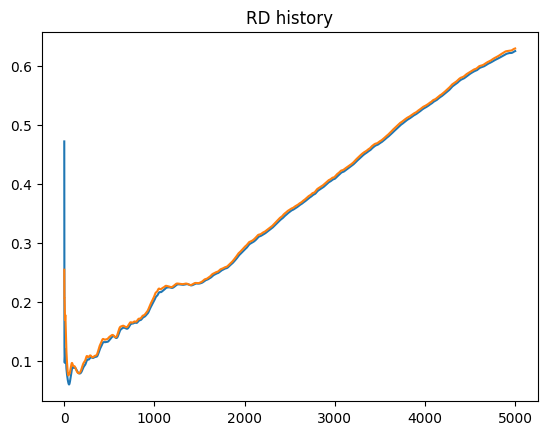

In [82]:
plt.plot(rd_diff_history_list[0], label="diff")
plt.plot(rd_react_history_list[0], label="react")
plt.title("RD history")

Text(0.5, 1.0, 'RD history')

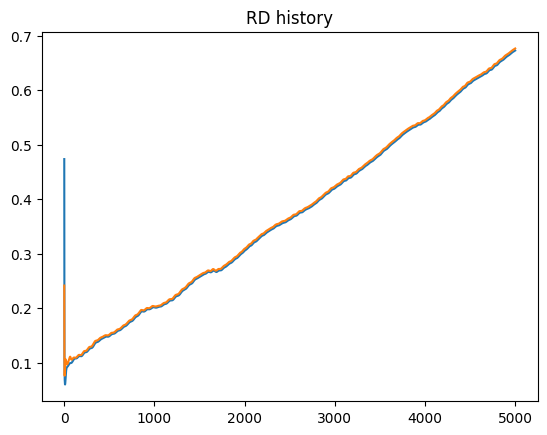

In [83]:
plt.plot(rd_diff_history_list[1], label="diff")
plt.plot(rd_react_history_list[1], label="react")
plt.title("RD history")

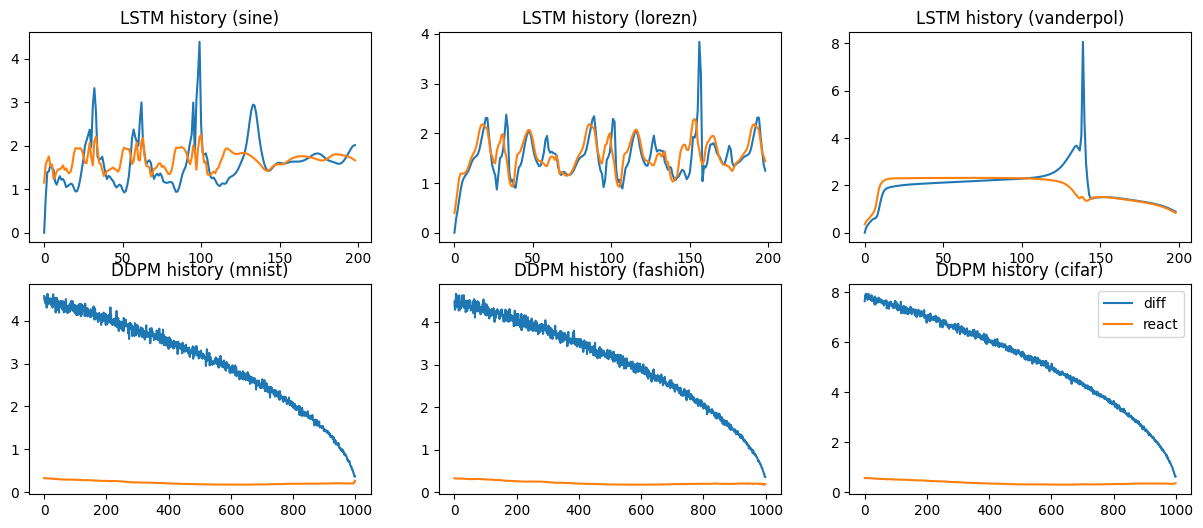

In [59]:
fig, ax = plt.subplots(2,3, figsize=(15,6))

ax[0,0].plot(lstm_diff_list_sine, label="diff")
ax[0,0].plot(lstm_react_list_sine, label="react")
ax[0,0].set_title("LSTM history (sine)")

ax[0,1].plot(lstm_diff_list_lorenz, label="diff")
ax[0,1].plot(lstm_react_list_lorenz, label="react")
ax[0,1].set_title("LSTM history (lorezn)")

ax[0,2].plot(lstm_diff_list_vanderpol, label="diff")
ax[0,2].plot(lstm_react_list_vanderpol, label="react")
ax[0,2].set_title("LSTM history (vanderpol)")

ax[1,0].plot(ddpm_diff_list_mnist, label="diff")
ax[1,0].plot(ddpm_react_list_mnist, label="react")
ax[1,0].set_title("DDPM history (mnist)")

ax[1,1].plot(ddpm_diff_list_fashion, label="diff")
ax[1,1].plot(ddpm_react_list_fashion, label="react")
ax[1,1].set_title("DDPM history (fashion)")

ax[1,2].plot(ddpm_diff_list_cifar, label="diff")
ax[1,2].plot(ddpm_react_list_cifar, label="react")
ax[1,2].set_title("DDPM history (cifar)")

plt.legend()
plt.show()

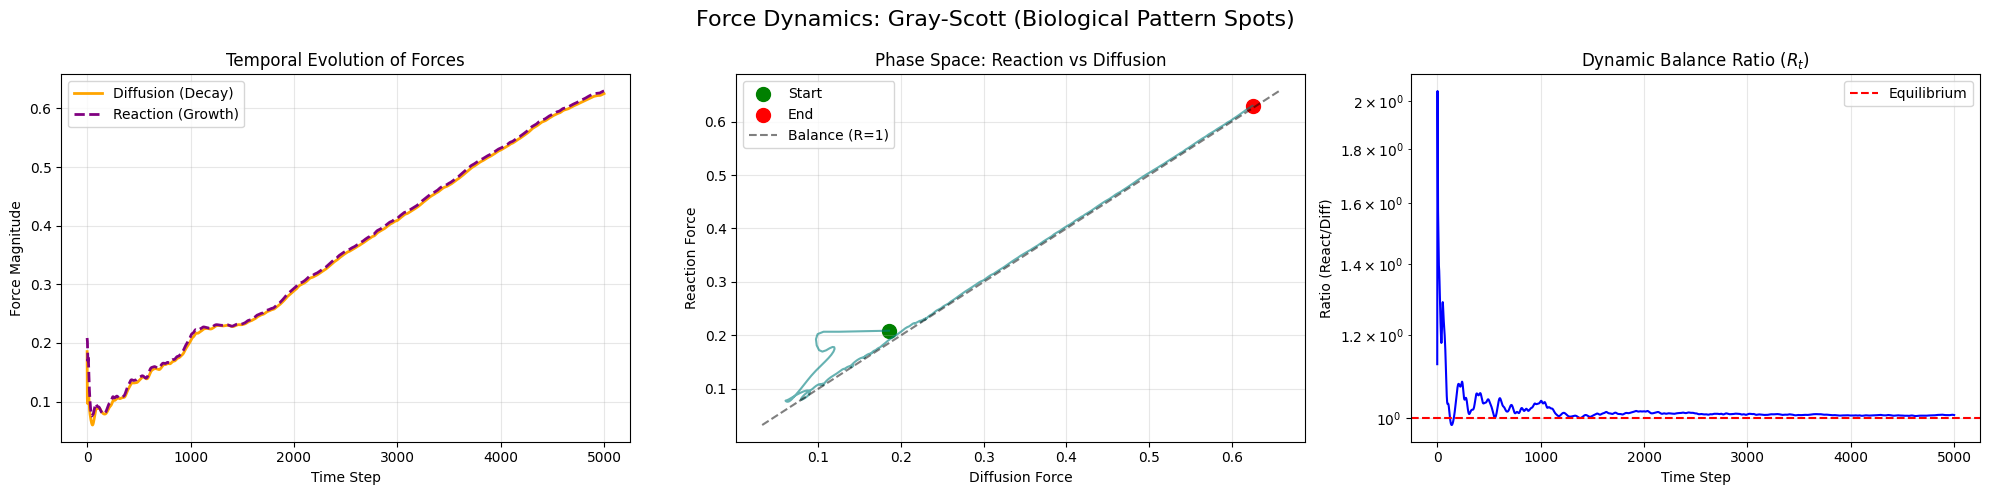

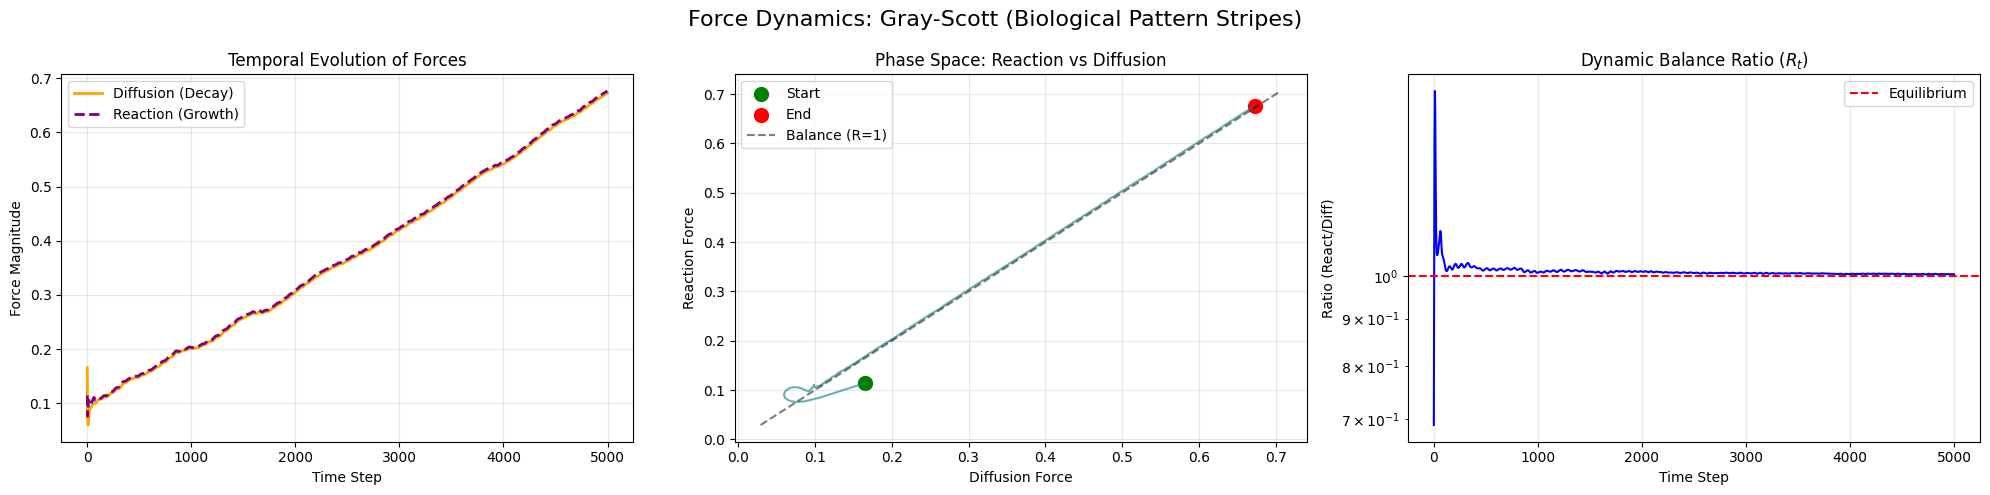

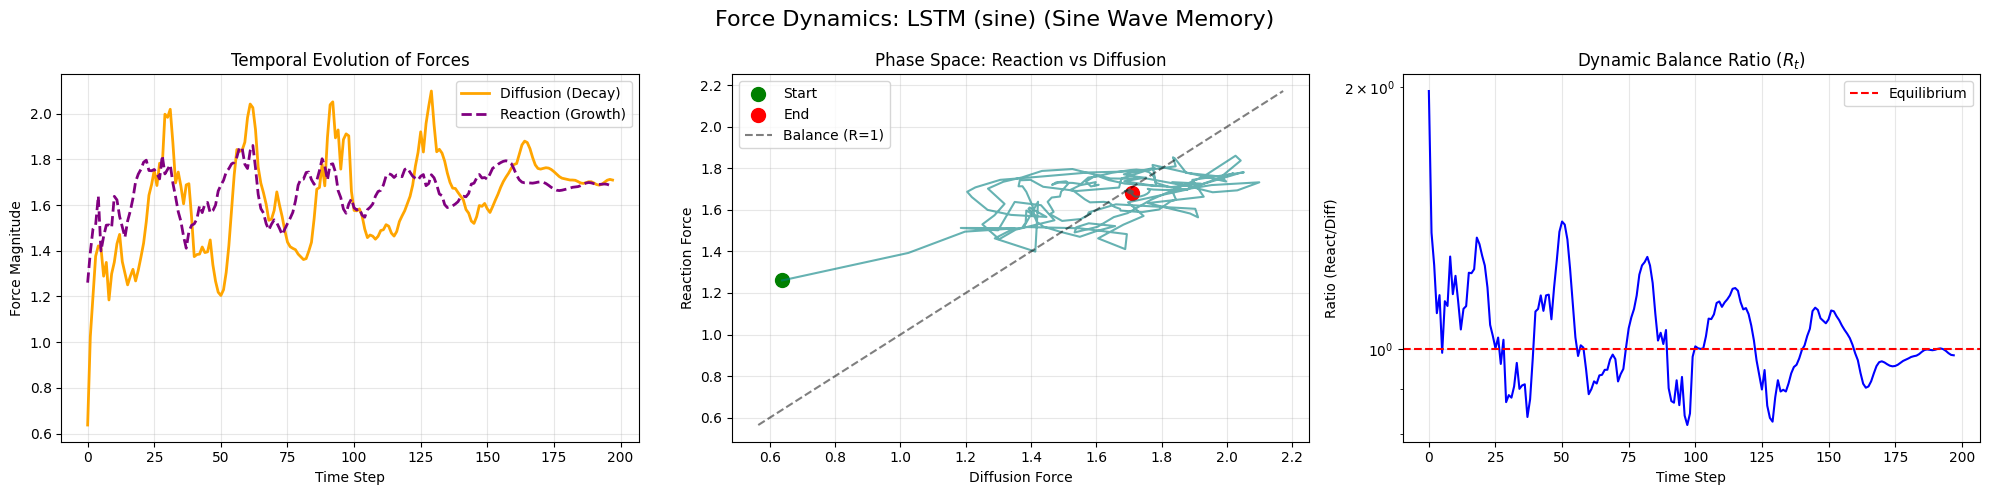

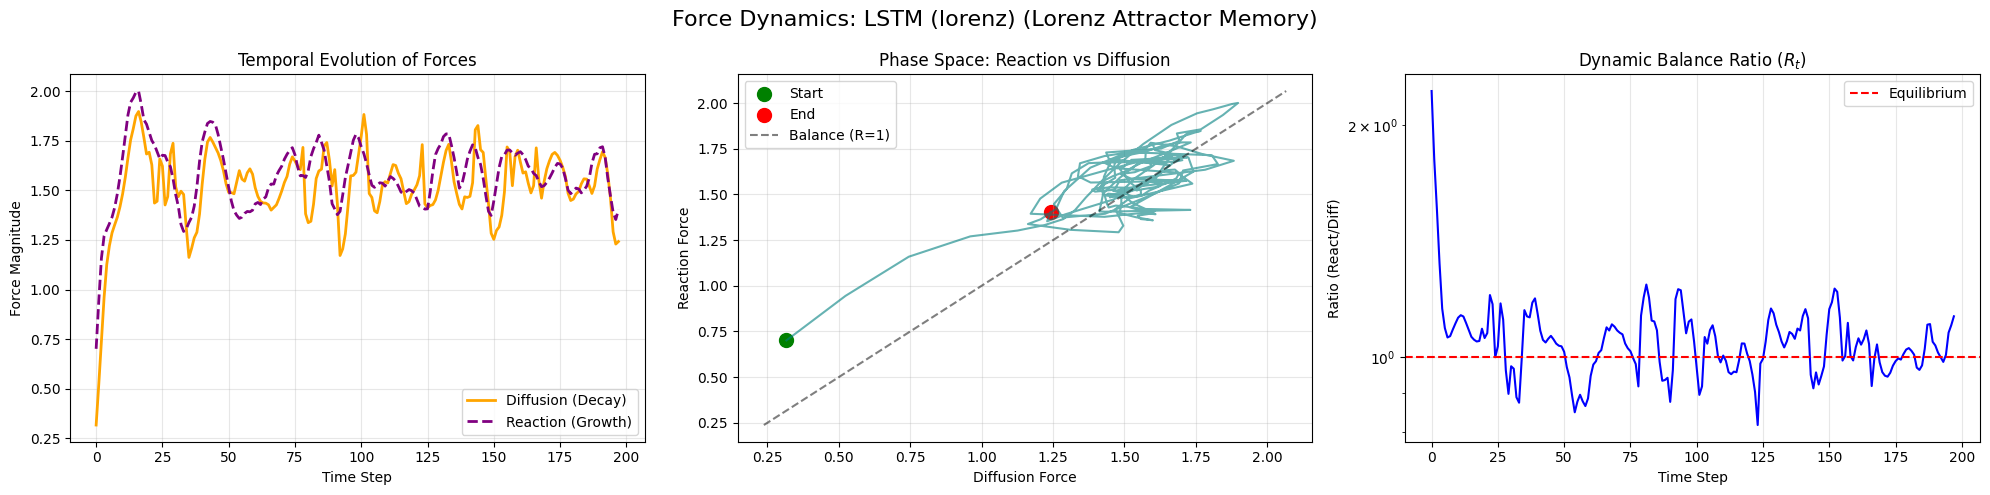

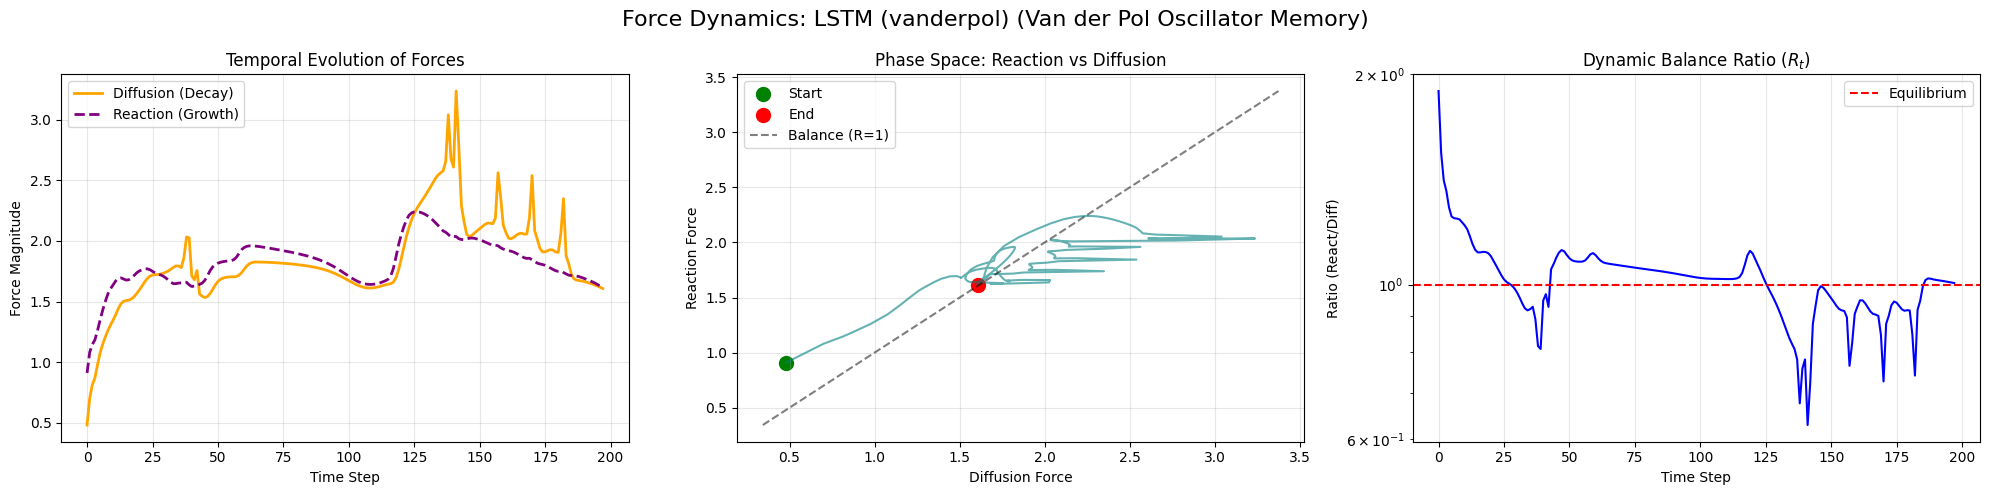

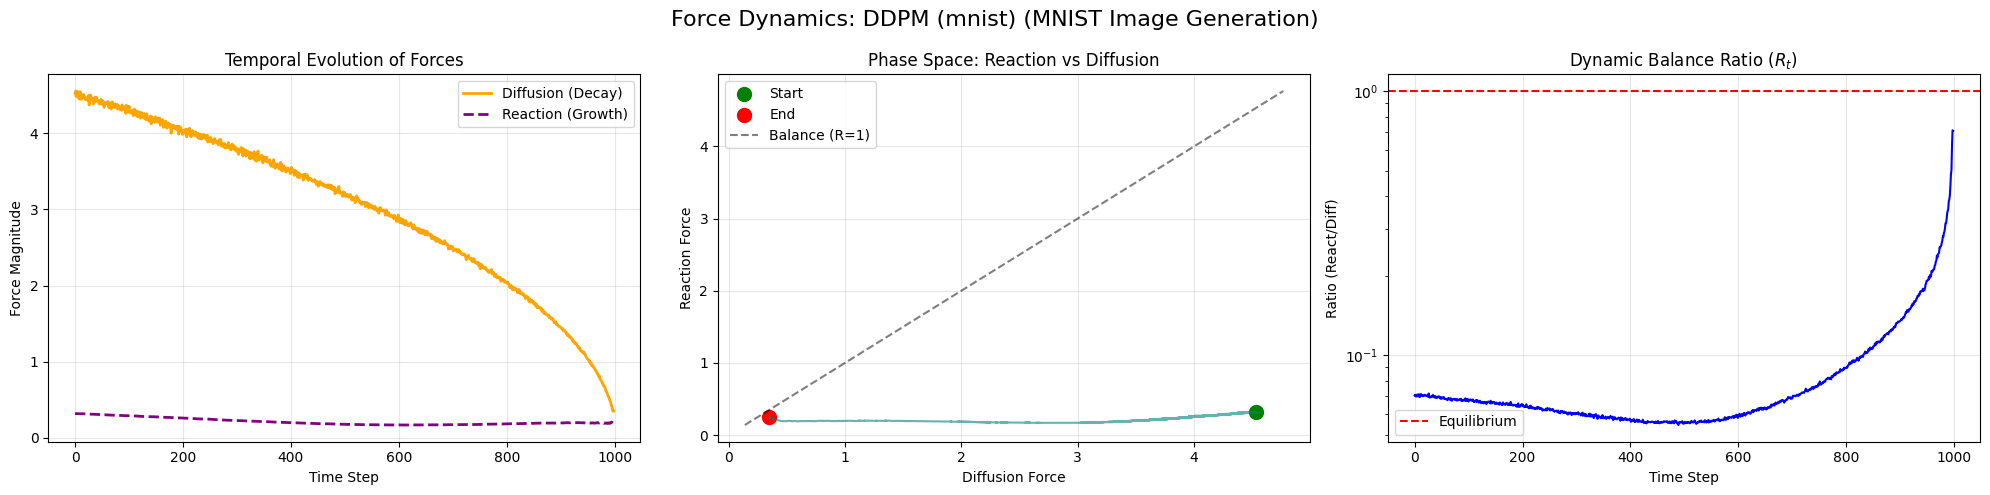

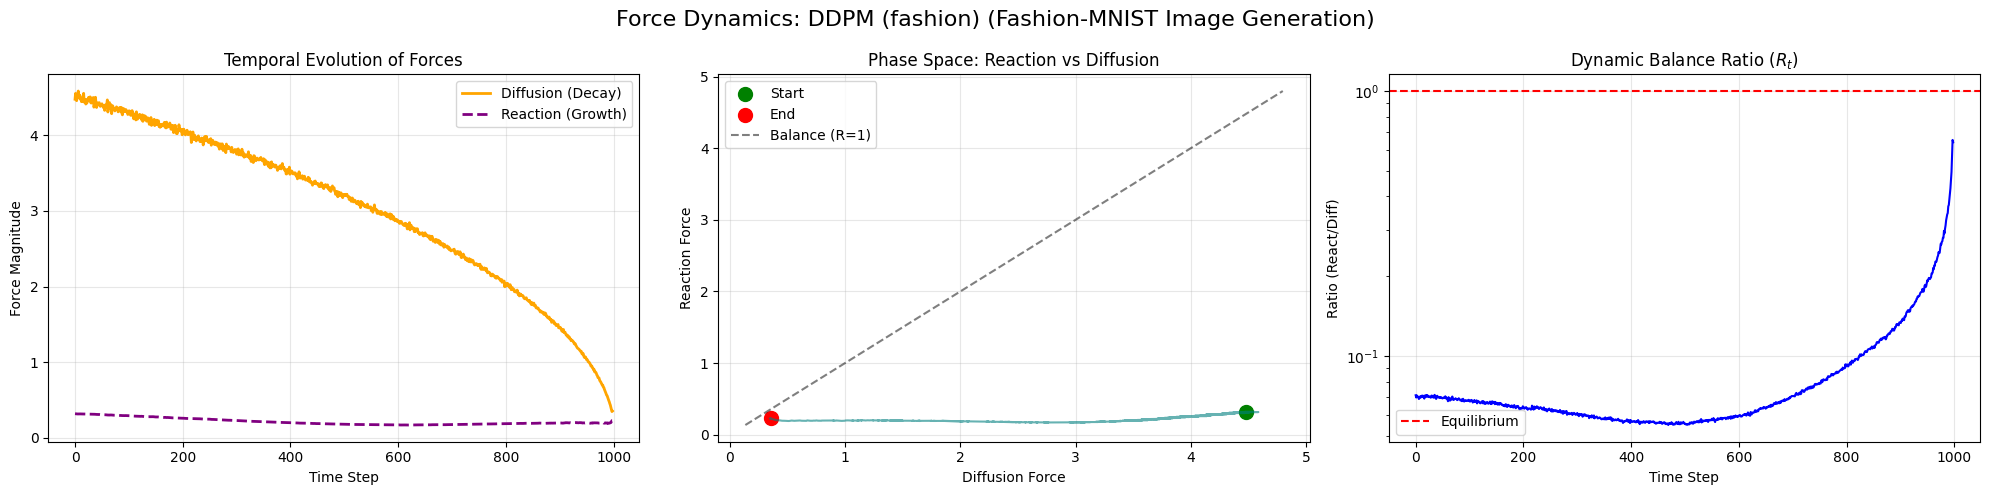

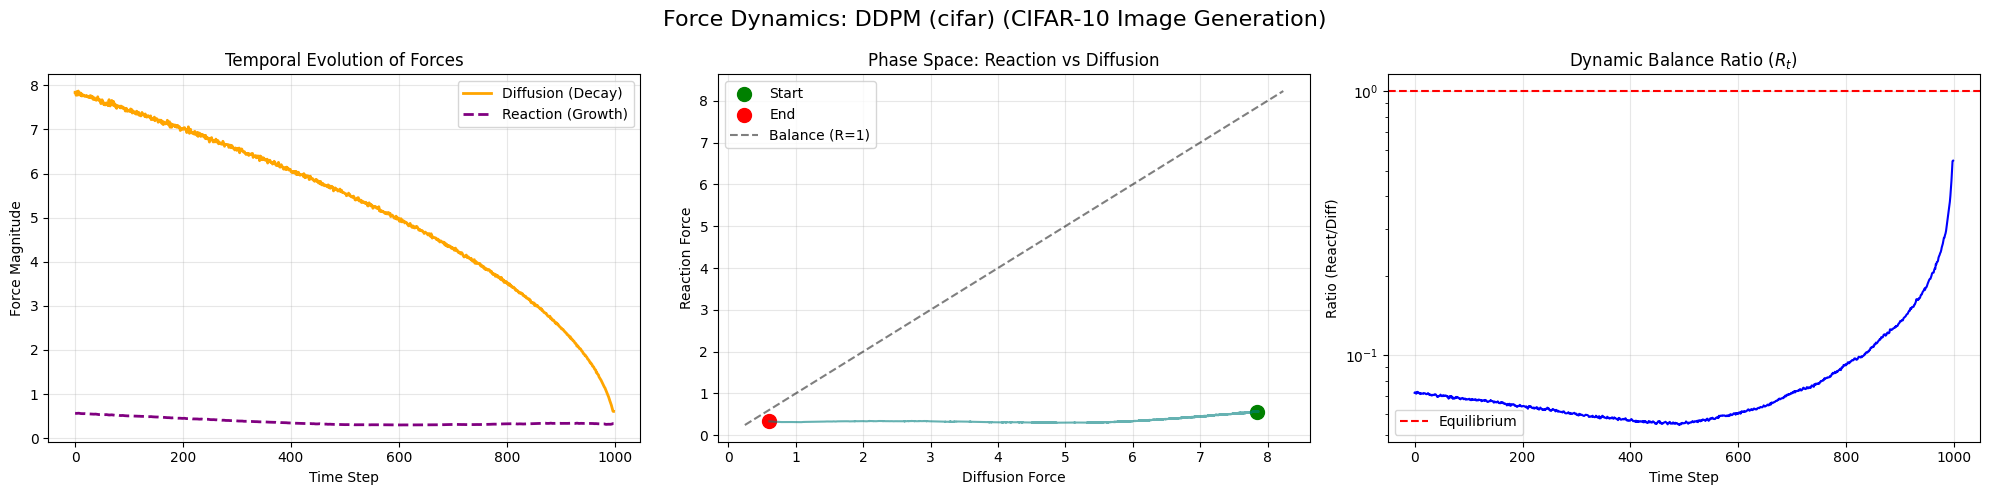

In [84]:
import matplotlib.pyplot as plt
import numpy as np

def analyze_forces(model_name, diff_forces, react_forces, task_type="Static"):
    """
    Generates a 3-panel analysis dashboard for a single model.
    """
    # Normalize time axis
    steps = np.arange(len(diff_forces))
    
    # # Smooth data for cleaner plotting (optional moving average)
    # def smooth(y, box_pts=10):
    #     if len(y) < 20: return y
    #     box = np.ones(box_pts)/box_pts
    #     return np.convolve(y, box, mode='same')

    # d_smooth = smooth(np.array(diff_forces))
    # r_smooth = smooth(np.array(react_forces))

    d_smooth = np.array(diff_forces)
    r_smooth = np.array(react_forces)

    fig, axes = plt.subplots(1, 3, figsize=(20, 5))
    plt.suptitle(f"Force Dynamics: {model_name} ({task_type})", fontsize=16)

    # --- Plot 1: Temporal Evolution (The "Battle") ---
    # Shows how forces compete over time
    axes[0].plot(steps, d_smooth, label='Diffusion (Decay)', color='orange', linewidth=2)
    axes[0].plot(steps, r_smooth, label='Reaction (Growth)', color='purple', linewidth=2, linestyle='--')
    axes[0].set_title("Temporal Evolution of Forces")
    axes[0].set_xlabel("Time Step")
    axes[0].set_ylabel("Force Magnitude")
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # --- Plot 2: Phase Space (The "Attractor") ---
    # Shows the system's stability signature
    axes[1].plot(d_smooth, r_smooth, color='teal', alpha=0.6)
    # Mark start and end
    axes[1].scatter(d_smooth[0], r_smooth[0], c='green', label='Start', s=100)
    axes[1].scatter(d_smooth[-1], r_smooth[-1], c='red', label='End', s=100)
    # Add y=x line (Perfect Balance)
    lims = [
        np.min([axes[1].get_xlim(), axes[1].get_ylim()]),  # min of both axes
        np.max([axes[1].get_xlim(), axes[1].get_ylim()]),  # max of both axes
    ]
    axes[1].plot(lims, lims, 'k--', alpha=0.5, label='Balance (R=1)')
    axes[1].set_title("Phase Space: Reaction vs Diffusion")
    axes[1].set_xlabel("Diffusion Force")
    axes[1].set_ylabel("Reaction Force")
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    # --- Plot 3: Balance Ratio Evolution ---
    # Shows how the "Goldilocks" ratio changes
    # Avoid div by zero
    ratio = r_smooth / (d_smooth + 1e-9)
    axes[2].plot(steps, ratio, color='blue')
    axes[2].axhline(y=1.0, color='r', linestyle='--', label='Equilibrium')
    axes[2].set_title("Dynamic Balance Ratio ($R_t$)")
    axes[2].set_xlabel("Time Step")
    axes[2].set_ylabel("Ratio (React/Diff)")
    axes[2].set_yscale('log') # Log scale often reveals more details
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return ratio

# Example Usage (Replace with your actual data variables)
ratio_rd_list_spot = analyze_forces("Gray-Scott", rd_diff_history_list[0][1:], rd_react_history_list[0][1:], "Biological Pattern Spots")
ratio_rd_list_stripe = analyze_forces("Gray-Scott", rd_diff_history_list[1][1:], rd_react_history_list[1][1:], "Biological Pattern Stripes")
ratio_lstm_list_sine = analyze_forces("LSTM (sine)", np.mean(np.array(lstm_diff_history_list_sine), axis=0)[1:], np.mean(np.array(lstm_react_history_list_sine), axis=0)[1:], "Sine Wave Memory")
ratio_lstm_list_lorenz = analyze_forces("LSTM (lorenz)", np.mean(np.array(lstm_diff_history_list_lorenz), axis=0)[1:], np.mean(np.array(lstm_react_history_list_lorenz), axis=0)[1:], "Lorenz Attractor Memory")
ratio_lstm_list_vanderpol = analyze_forces("LSTM (vanderpol)", np.mean(np.array(lstm_diff_history_list_vanderpol), axis=0)[1:], np.mean(np.array(lstm_react_history_list_vanderpol), axis=0)[1:], "Van der Pol Oscillator Memory")
ratio_ddpm_list_mnist = analyze_forces("DDPM (mnist)", np.mean(np.array(ddpm_diff_history_list_mnist), axis=0)[1:], np.mean(np.array(ddpm_react_history_list_mnist), axis=0)[1:], "MNIST Image Generation")
ratio_ddpm_list_fashion = analyze_forces("DDPM (fashion)", np.mean(np.array(ddpm_diff_history_list_fashion), axis=0)[1:], np.mean(np.array(ddpm_react_history_list_fashion), axis=0)[1:], "Fashion-MNIST Image Generation")
ratio_ddpm_list_cifar = analyze_forces("DDPM (cifar)", np.mean(np.array(ddpm_diff_history_list_cifar), axis=0)[1:], np.mean(np.array(ddpm_react_history_list_cifar), axis=0)[1:], "CIFAR-10 Image Generation")

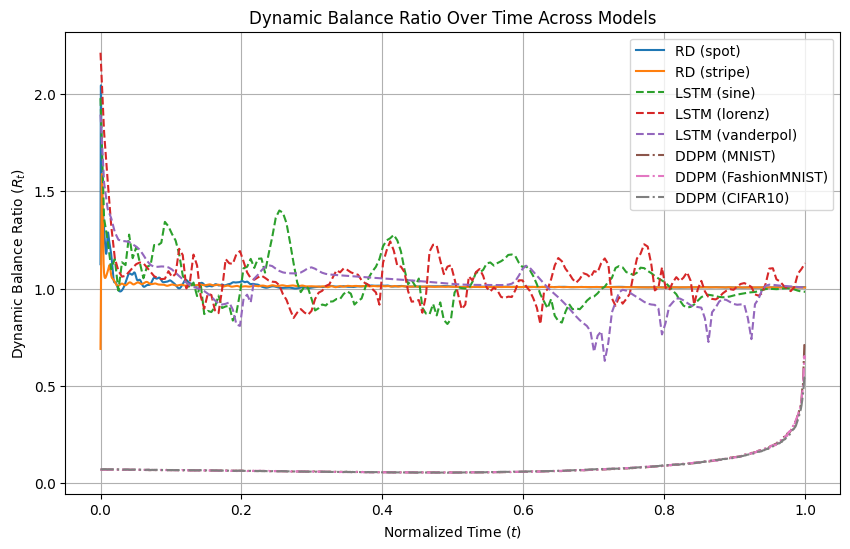

In [103]:
n0 = len(ratio_rd_list_spot)
n1 = len(ratio_lstm_list_sine)
n2 = len(ratio_ddpm_list_mnist)

plt.figure(figsize=(10,6))
# plt.axhline(y=1.0, color='black', linestyle='-', label='Equilibrium')

plt.plot(np.linspace(0,1, n0), ratio_rd_list_spot, label="RD (spot)")
plt.plot(np.linspace(0,1, n0), ratio_rd_list_stripe, label="RD (stripe)")
plt.plot(np.linspace(0,1, n1), ratio_lstm_list_sine, label="LSTM (sine)", linestyle='--')
plt.plot(np.linspace(0,1, n1), ratio_lstm_list_lorenz, label="LSTM (lorenz)", linestyle='--')
plt.plot(np.linspace(0,1, n1), ratio_lstm_list_vanderpol, label="LSTM (vanderpol)", linestyle='--')
plt.plot(np.linspace(0,1, n2), ratio_ddpm_list_mnist, label="DDPM (MNIST)", linestyle='-.')
plt.plot(np.linspace(0,1, n2), ratio_ddpm_list_fashion, label="DDPM (FashionMNIST)", linestyle='-.')
plt.plot(np.linspace(0,1, n2), ratio_ddpm_list_cifar, label="DDPM (CIFAR10)", linestyle='-.')

# plt.yscale('log') # Log scale often reveals more details
plt.xlabel("Normalized Time ($t$)")
plt.ylabel("Dynamic Balance Ratio ($R_t$)")
plt.title("Dynamic Balance Ratio Over Time Across Models")
plt.grid()
plt.legend()

In [102]:
print("rd spot final value: ", ratio_rd_list_spot[-1])
print("rd stripe final value: ", ratio_rd_list_stripe[-1])
print("lstm sine final value: ", ratio_lstm_list_sine[-1])
print("lstm lorenz final value: ", ratio_lstm_list_lorenz[-1])
print("lstm vanderpol final value: ", ratio_lstm_list_vanderpol[-1])
print("ddpm mnist final value: ", ratio_ddpm_list_mnist[-1])
print("ddpm fashion final value: ", ratio_ddpm_list_fashion[-1])
print("ddpm cifar final value: ", ratio_ddpm_list_cifar[-1])

rd spot final value:  1.0069979728484462
rd stripe final value:  1.0055568894156415
lstm sine final value:  0.9837723346237862
lstm lorenz final value:  1.1304590585941465
lstm vanderpol final value:  1.004997721741786
ddpm mnist final value:  0.7078891608932647
ddpm fashion final value:  0.640834678482592
ddpm cifar final value:  0.5448761058435498
